# **Bank Marketing Data Analysis**

ITEC-600 Final Project

Group: ITEC600_G3

Name: Shu-Wen Teng, Soyoung Yoon, Yen-Jo Lee, Yen-Chun Lin


## **Project Objective**:
This project aims to predict the likelihood of customers subscribing to term deposits based on campaign data. Additionally, it seeks to provide actionable insights to help the bank enhance its direct marketing strategies.

## **Key Questions**:
-  Business Question: How can the bank optimize its direct marketing strategies to increase term deposit subscriptions?
-  Analytics Question: What factors most significantly influence a customer’s likelihood to subscribe following a marketing campaign?

By addressing these questions, the project will enable the bank to identify key drivers of customer behavior, tailor marketing efforts more effectively, and improve overall campaign performance.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, f1_score, mean_squared_error
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import statsmodels.api as sm
import io
import requests
import zipfile


## **Bank Marketing Dataset Description**

This dataset contains information about a direct marketing campaign of a Portuguese banking institution. The target variable `y` indicates whether a client subscribed to a term deposit.


## Variables

| Variable Name | Role      | Type        | Demographic       | Description                                                                                                       | Units        | Missing Values |
|---------------|-----------|-------------|-------------------|-------------------------------------------------------------------------------------------------------------------|--------------|----------------|
| `age`         | Feature   | Integer     | Age               | Age of the client                                                                                                | -            | No             |
| `job`         | Feature   | Categorical | Occupation        | Type of job (e.g., 'admin.', 'blue-collar', 'entrepreneur', etc.)                                                 | -            | No             |
| `marital`     | Feature   | Categorical | Marital Status    | Marital status (e.g., 'divorced', 'married', 'single')                                                           | -            | No             |
| `education`   | Feature   | Categorical | Education Level   | Level of education (e.g., 'basic.4y', 'university.degree', 'high.school')                                        | -            | No             |
| `default`     | Feature   | Binary      | -                 | Whether the client has credit in default (yes/no)                                                                | -            | No             |
| `balance`     | Feature   | Integer     | -                 | Average yearly balance of the client                                                                             | Euros        | No             |
| `housing`     | Feature   | Binary      | -                 | Whether the client has a housing loan (yes/no)                                                                   | -            | No             |
| `loan`        | Feature   | Binary      | -                 | Whether the client has a personal loan (yes/no)                                                                  | -            | No             |
| `contact`     | Feature   | Categorical | -                 | Contact communication type (e.g., 'cellular', 'telephone')                                                       | -            | Yes            |
| `day_of_week` | Feature   | Date        | -                 | Last contact day of the week                                                                                     | -            | No             |
| `month`       | Feature   | Date        | -                 | Last contact month of the year (e.g., 'jan', 'feb', ..., 'dec')                                                  | -            | No             |
| `duration`    | Feature   | Integer     | -                 | Last contact duration in seconds. **Note**: Use only for benchmarking; discard for realistic predictive modeling. | Seconds      | No             |
| `campaign`    | Feature   | Integer     | -                 | Number of contacts performed during this campaign for this client                                                | -            | No             |
| `pdays`       | Feature   | Integer     | -                 | Number of days since the client was last contacted from a previous campaign (-1 indicates no prior contact)       | Days         | Yes            |
| `previous`    | Feature   | Integer     | -                 | Number of contacts performed before this campaign for this client                                                | -            | No             |
| `poutcome`    | Feature   | Categorical | -                 | Outcome of the previous marketing campaign (e.g., 'failure', 'success')                                          | -            | Yes            |
| `y`           | Target    | Binary      | -                 | Whether the client subscribed to a term deposit (yes/no)                                                         | -            | No             |

## Notes:
- The `duration` variable significantly affects the target variable `y`. If `duration = 0`, then `y = no`. This variable should **not** be used for realistic predictive modeling, as its value is only known after a contact is made.
- Missing values are present in the `contact`, `pdays`, and `poutcome` features and need to be handled appropriately.



## **Data Overview**
The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

-  Source: UC Irvine Machine Learning Repository
-  Size: 45211 observations and 17 variables

In [ ]:
# Load dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip"

# Download the zip file
response = requests.get(url)
response.raise_for_status()  # Raise an exception for bad responses

# Extract the desired file from the zip
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    with z.open("bank-full.csv") as f:  # Specify the file you want
        df = pd.read_csv(f, delimiter=';')  # Read the CSV data



In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [ ]:
# Undersample to make is a balance data

majority_class = df[df['y'] == 'no']
minority_class = df[df['y'] == 'yes']

from sklearn.utils import resample

# Undersample the majority class
majority_undersampled = resample(
    majority_class,
    replace=False,
    n_samples=len(minority_class),
    random_state=42
)

balanced_df = pd.concat([majority_undersampled, minority_class])

balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)


In [ ]:
print(balanced_df['y'].value_counts())

y
yes    5289
no     5289
Name: count, dtype: int64


In [ ]:
balanced_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,39,management,divorced,tertiary,no,517,yes,yes,unknown,14,may,1328,1,-1,0,unknown,yes
1,30,services,married,secondary,no,3929,yes,no,cellular,20,nov,593,1,-1,0,unknown,yes
2,46,management,divorced,tertiary,no,624,no,no,cellular,18,mar,420,1,276,1,other,yes
3,32,admin.,married,tertiary,no,653,no,no,cellular,2,jun,84,1,-1,0,unknown,yes
4,36,blue-collar,married,primary,no,319,yes,no,cellular,13,may,774,2,301,1,failure,yes


In [ ]:
# Convert target variable to binary (if not already done)
balanced_df['y'] = balanced_df['y'].map({'yes': 1, 'no': 0})

# Validate the target variable (no conversion needed)
print("Target Variable Distribution:")
print(balanced_df['y'].value_counts())

# Separate features and target variable
X = balanced_df.drop(columns=['y'])
y = balanced_df['y']

# Identify categorical and numerical columns
categorical_columns = X.select_dtypes(include=['object']).columns
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns

# Preprocessing pipeline
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

Target Variable Distribution:
y
1    5289
0    5289
Name: count, dtype: int64


In [ ]:
# Display basic info and missing values
print(balanced_df.info())
print("\nMissing Values:\n", balanced_df.isnull().sum())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10578 entries, 0 to 10577
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        10578 non-null  int64 
 1   job        10578 non-null  object
 2   marital    10578 non-null  object
 3   education  10578 non-null  object
 4   default    10578 non-null  object
 5   balance    10578 non-null  int64 
 6   housing    10578 non-null  object
 7   loan       10578 non-null  object
 8   contact    10578 non-null  object
 9   day        10578 non-null  int64 
 10  month      10578 non-null  object
 11  duration   10578 non-null  int64 
 12  campaign   10578 non-null  int64 
 13  pdays      10578 non-null  int64 
 14  previous   10578 non-null  int64 
 15  poutcome   10578 non-null  object
 16  y          10578 non-null  int64 
dtypes: int64(8), object(9)
memory usage: 1.4+ MB
None

Missing Values:
 age          0
job          0
marital      0
education    0
default      0
ba

## **EDA(Exploratory Data Analysis) and Preprocessing**

<ipython-input-11-fb3097af41db>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='y', palette="pastel")


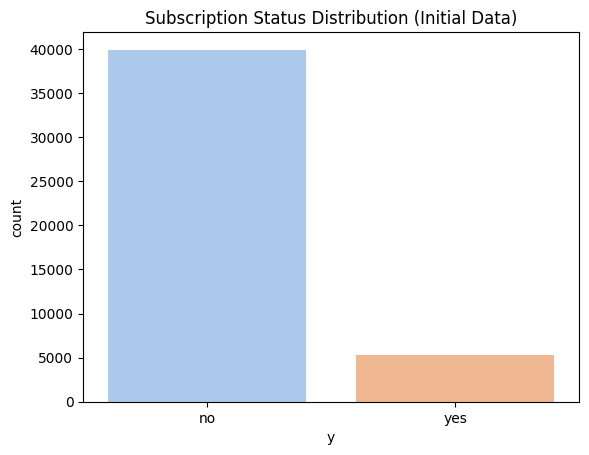

In [ ]:
# EDA
import seaborn as sns
import matplotlib.pyplot as plt

# Bar plot for the target variable
sns.countplot(data=df, x='y', palette="pastel")
plt.title("Subscription Status Distribution (Initial Data)")
plt.show()

The initial dataset is imbalanced, containing 39,922 observations of "not subscribed" and 5,289 observations of "subscribed."

<ipython-input-12-6d8665aa8044>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=balanced_df, x='y', palette="pastel")


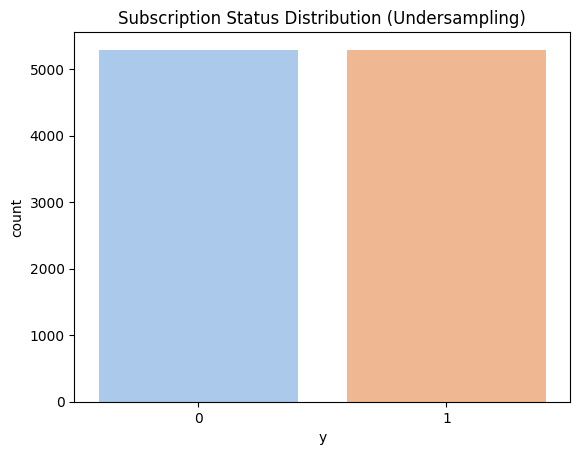

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Bar plot for the target variable
sns.countplot(data=balanced_df, x='y', palette="pastel")
plt.title("Subscription Status Distribution (Undersampling)")
plt.show()

Undersampling is applied to create a balanced dataset, with 5,289 observations for each class.

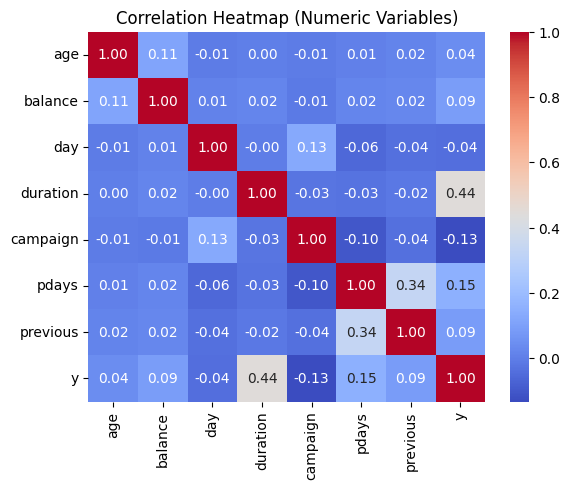

In [ ]:
# Select only numeric columns for the correlation matrix
numeric_df = balanced_df.select_dtypes(include=['int64', 'float64'])
corr_matrix = numeric_df.corr()

# Plot the heatmap
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap (Numeric Variables)")
plt.show()


The strongest correlation with the target variable (y) is with duration, suggesting that the length of the communication may be the most predictive numerical feature for a successful subscription.
The overall pattern of weak correlations between y and other features suggests that other factors, potentially categorical variables, might be more impactful for predicting subscription status.

<ipython-input-14-caaa6ff7a816>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=balanced_df, x='y', y=col, palette="pastel", ax=axes[i])
<ipython-input-14-caaa6ff7a816>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=balanced_df, x='y', y=col, palette="pastel", ax=axes[i])
<ipython-input-14-caaa6ff7a816>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=balanced_df, x='y', y=col, palette="pastel", ax=axes[i])
<ipython-input-14-caaa6ff7a816>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and wi

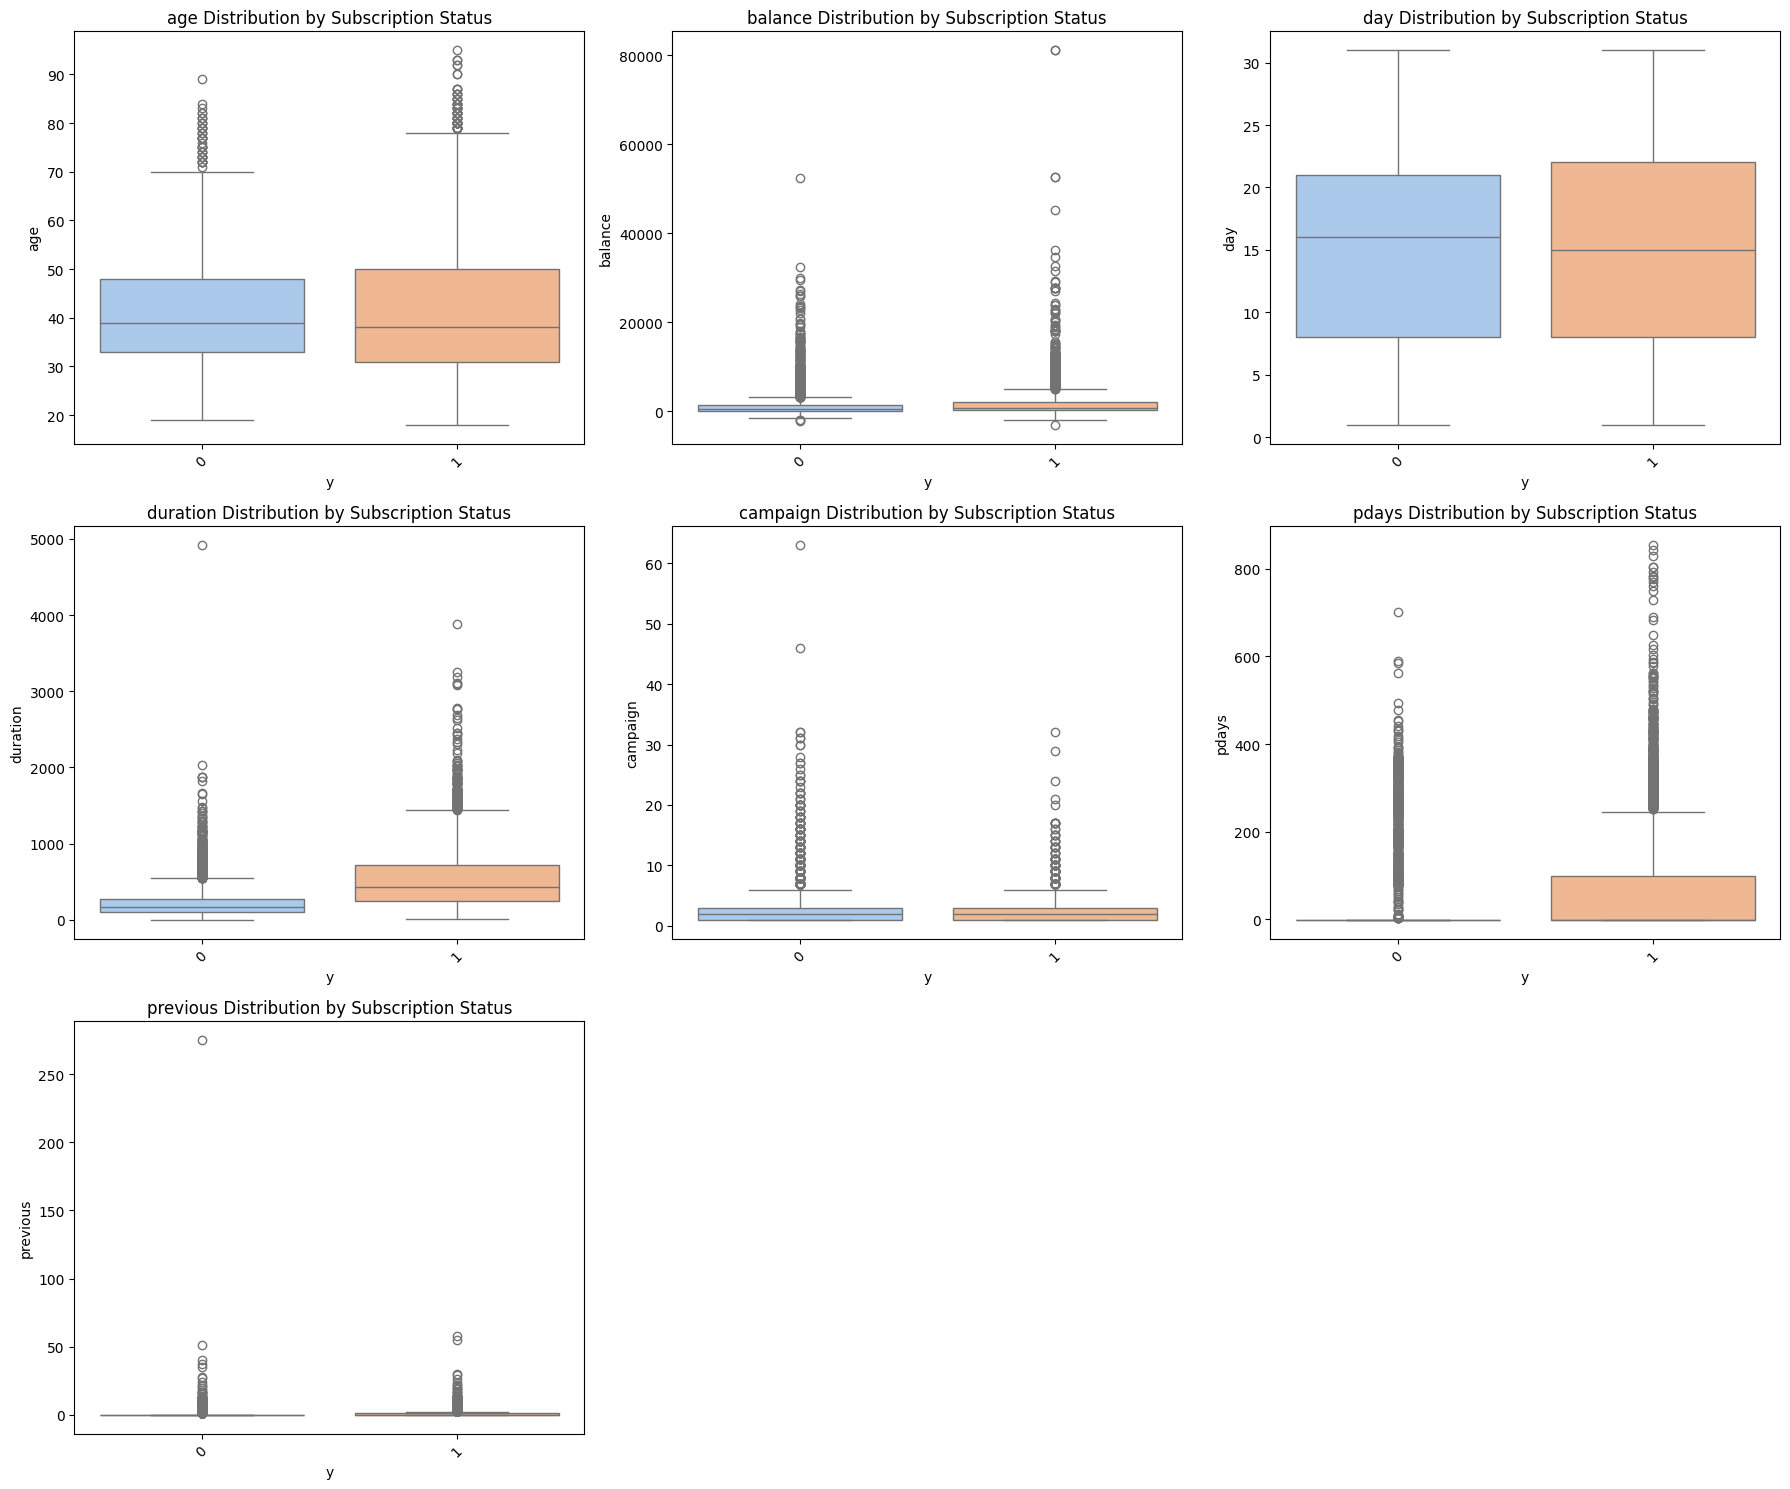

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of numerical variables
numerical_vars = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Create a 3x3 grid for the subplots (adjust the grid size as needed)
fig, axes = plt.subplots(3, 3, figsize=(18, 15))  # Adjust figure size as needed
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

# Plot each numerical variable in the subplot grid
for i, col in enumerate(numerical_vars):
    sns.boxplot(data=balanced_df, x='y', y=col, palette="pastel", ax=axes[i])
    axes[i].set_title(f"{col} Distribution by Subscription Status")
    axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

# Hide any unused subplots if there are fewer plots than subplots
for j in range(len(numerical_vars), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to make space for titles and labels
plt.tight_layout()
plt.show()


Boxplots for the numerical variables.
Focus on whether the differences in medians and distributions between subscribers and non-subscribers are significant.
Variables like duration and pdays show potential trends that could be related to subscription status, with significant differences in median and distribution between subscribers and non-subscribers.
Age, balance, day, campaign, and pervious show similar distributions across groups, suggesting they might be less important in distinguishing subscription status.
There are noticeable outliers in variables such as balance, duration, and campaign. These data points may represent special cases or unique customer segments that could warrant further analysis. Since our goal is to identify which features influence the outcome and improve predictive accuracy, we have decided not to remove these outliers. These data points could provide valuable information for the subsequent analysis, so we will retain them.


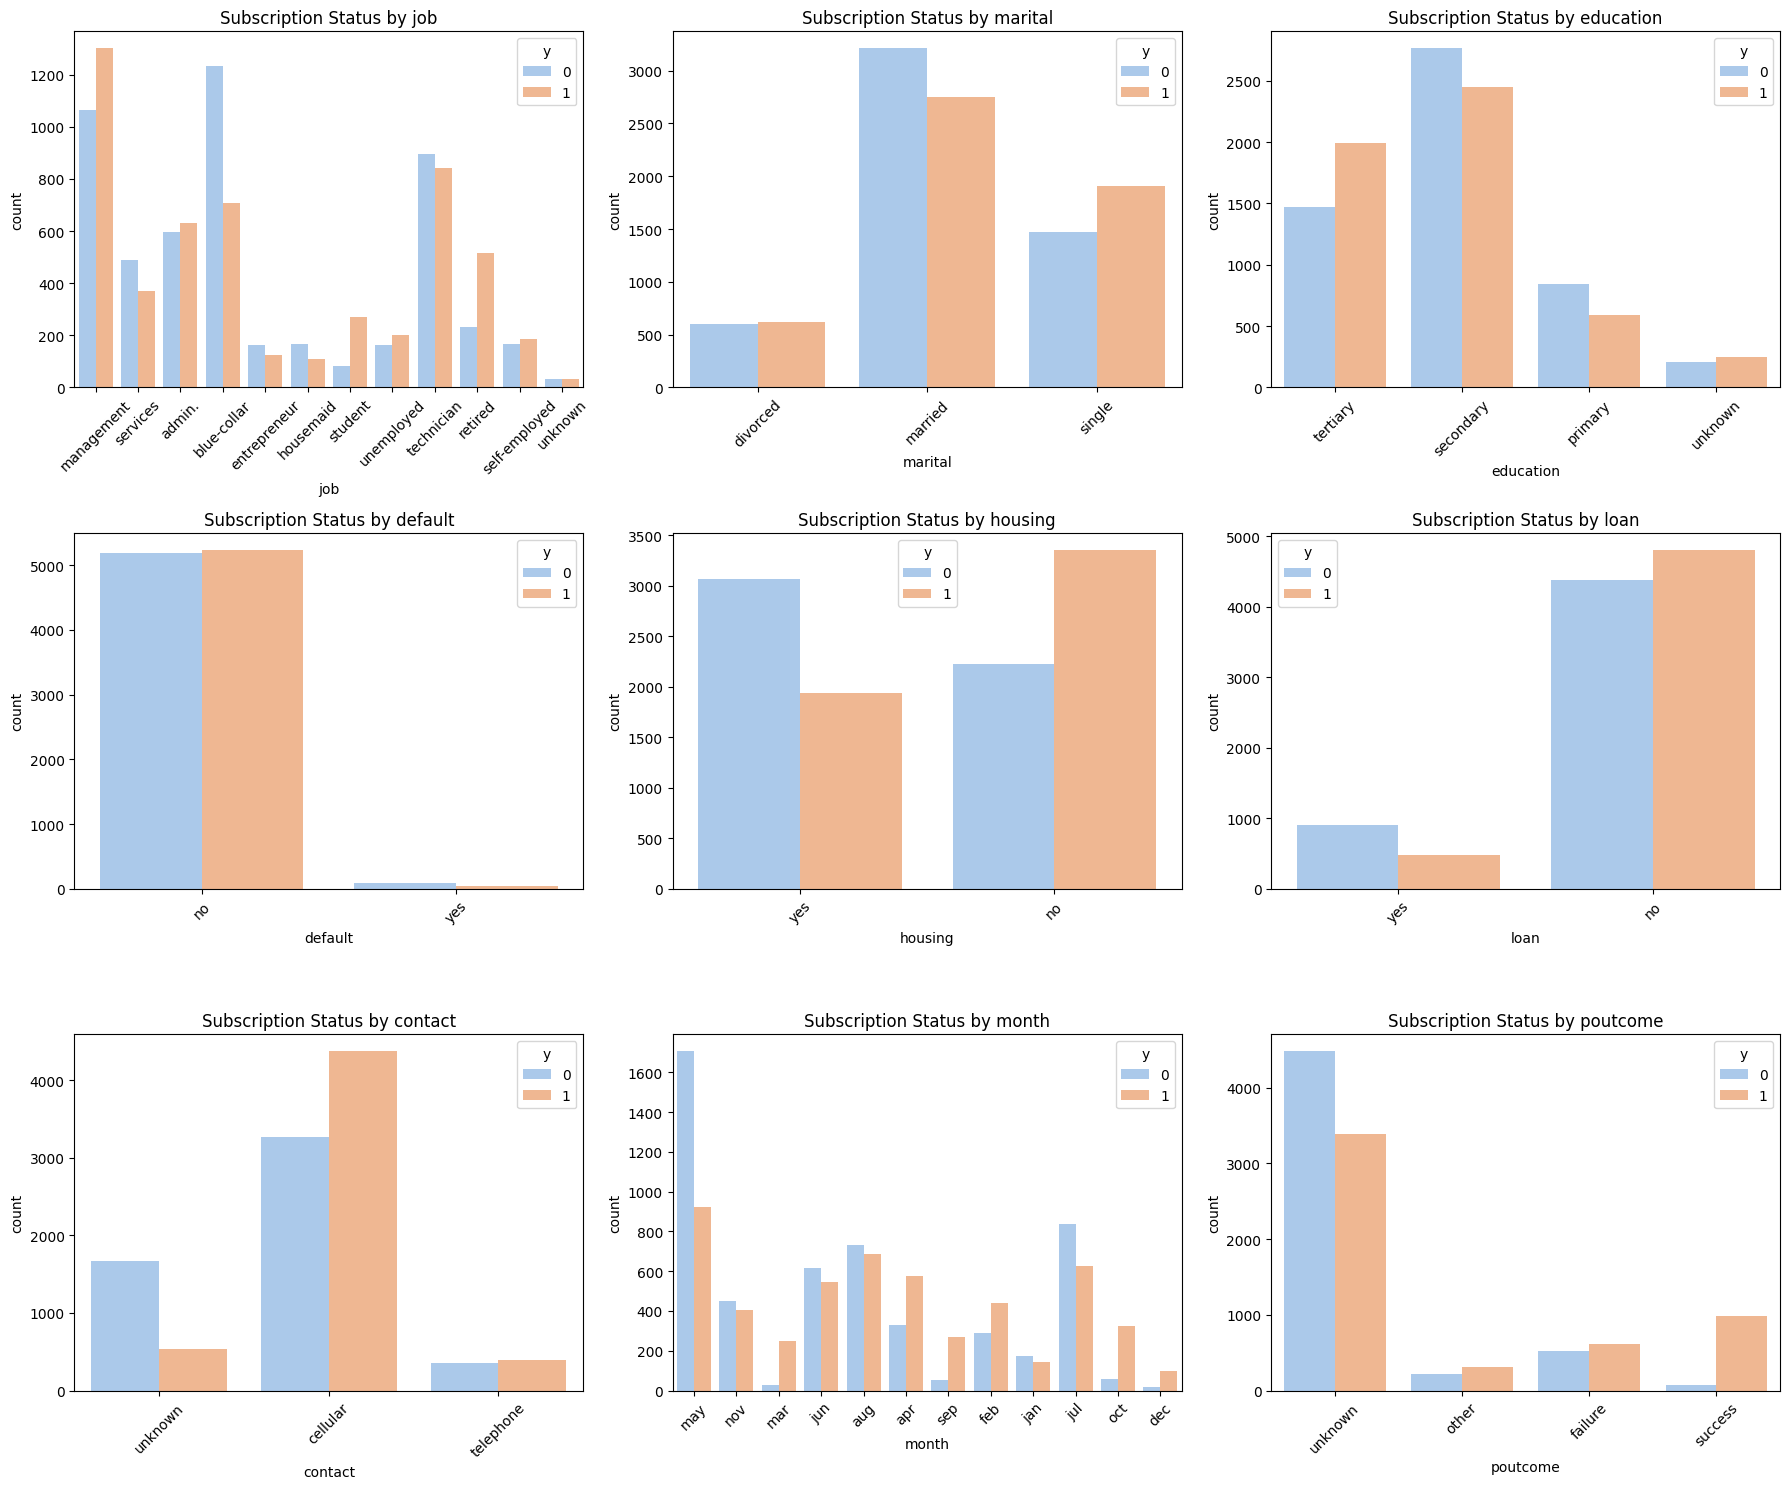

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of categorical variables
categorical_vars = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']



# Create subplots for a more compact display (adjust rows/columns as needed)
fig, axes = plt.subplots(3, 3, figsize=(18, 15))  # Adjust figure size for the subplot grid
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

# Plot each categorical variable in the subplot grid
for i, col in enumerate(categorical_vars):
    sns.countplot(data=balanced_df, x=col, hue='y', palette="pastel", ax=axes[i])
    axes[i].set_title(f"Subscription Status by {col}")
    axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for readability

# Adjust layout to make space for titles and labels
plt.tight_layout()
plt.show()

People who tend to have higher subscription rates are characterized by the following:

Job: Management, Administrative, Technician
Marital Status: Married
Education: Secondary, Tertiary
Default: No
Housing Loan: No
Personal Loan: No
Contact Method: Cellular


In [ ]:
# Apply preprocessing
X_preprocessed = preprocessor.fit_transform(X)

# Convert preprocessed data to a DataFrame for statsmodels
# Get feature names after one-hot encoding
categorical_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_columns)
feature_names = np.concatenate([numerical_columns, categorical_feature_names])
X_preprocessed_df = pd.DataFrame(X_preprocessed.toarray(), columns=feature_names)

# Add constant for statsmodels
X_preprocessed_df = sm.add_constant(X_preprocessed_df)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed_df, y, test_size=0.2, random_state=42, stratify=y)

# Logistic Regression using statsmodels
logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()

# Print summary to see p-values and coefficients
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.405707
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 8462
Model:                          Logit   Df Residuals:                     8419
Method:                           MLE   Df Model:                           42
Date:                Thu, 12 Dec 2024   Pseudo R-squ.:                  0.4147
Time:                        16:17:01   Log-Likelihood:                -3433.1
converged:                       True   LL-Null:                       -5865.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.2892      0.225      5.733      0.000       0.848       1.730
ag

The logistic regression model was utilized to analyze the likelihood of clients subscribing to a term deposit. For the demographic group, age was found to be statistically insignificant in influencing subscription likelihood. Clients with tertiary education and students had a significant positive influence, indicating a higher likelihood of subscribing to a term deposit. Single clients showed a slightly higher likelihood of subscribing, but this variable was not statistically significant.
For financial features, clients without housing or personal loans were significantly more likely to subscribe to a term deposit. Higher account balances positively influenced subscription likelihood due to their significant p-value and positive slope.
For campaign-related features, longer call durations were strongly associated with a higher likelihood of subscription, demonstrating the most significant impact among campaign-related variables. A higher number of contact attempts during the campaign reduced the likelihood of subscription, suggesting potential diminishing returns from excessive contact.

## **Hypotheses and Analytical Approach**

**Key Hypotheses**:
-  Financial stability(e.g. balance) increases subscription likelihood
-  Campaign effectiveness (e.g., duration, poutcome) drives success

Age: Older customers may be more likely to subscribe to term deposits due to risk aversion.

Balance: Customers with higher account balances might have a higher propensity to invest in a term deposit.

Duration: A longer last contact duration may indicate a more engaged conversation, positively influencing subscription rates.

Campaign (Number of Contacts): Too many contacts might annoy customers, reducing the likelihood of subscription.

**Analytical Approach**:
-  Balance dataset using undersampling
-  Explore various machine learning models, including Logistic Regression, Decision Trees, Random Forest, and SVM, to evaluate predictive performance


In [ ]:
# Logistic Regression Report
# Using the previously defined y_pred and y_test
report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'])

# Print the classification report
print(report)



NameError: name 'y_pred' is not defined

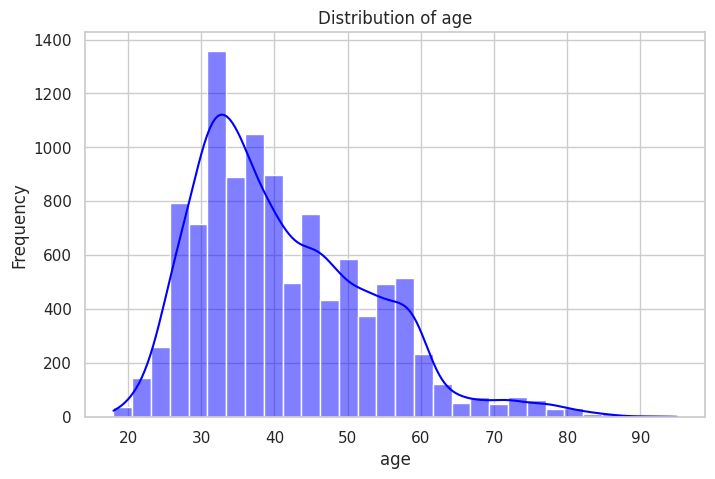

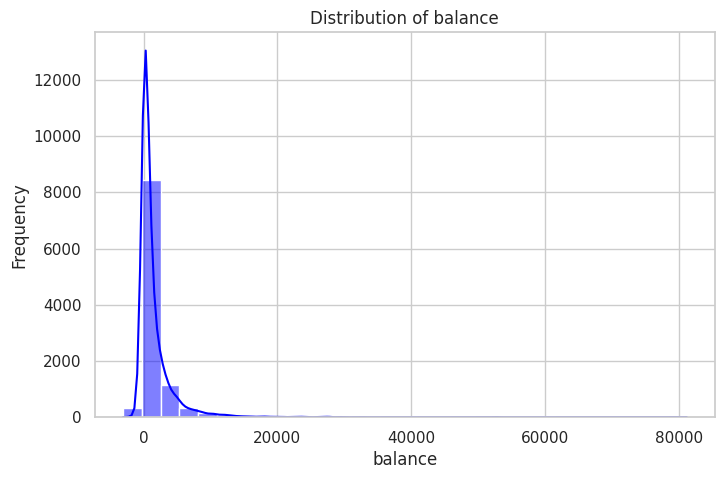

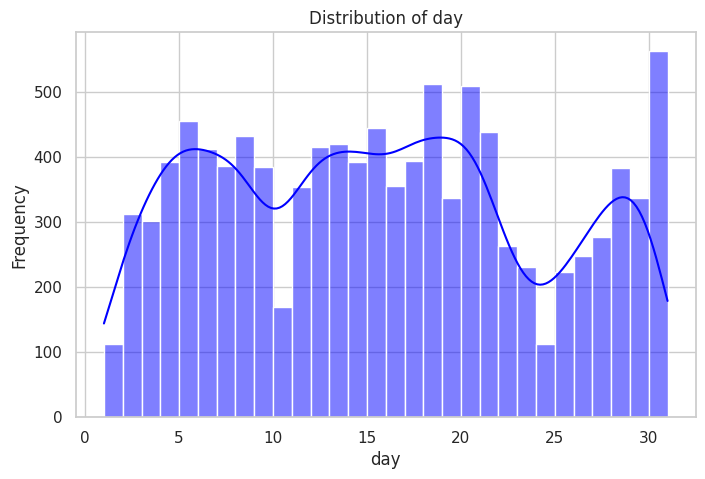

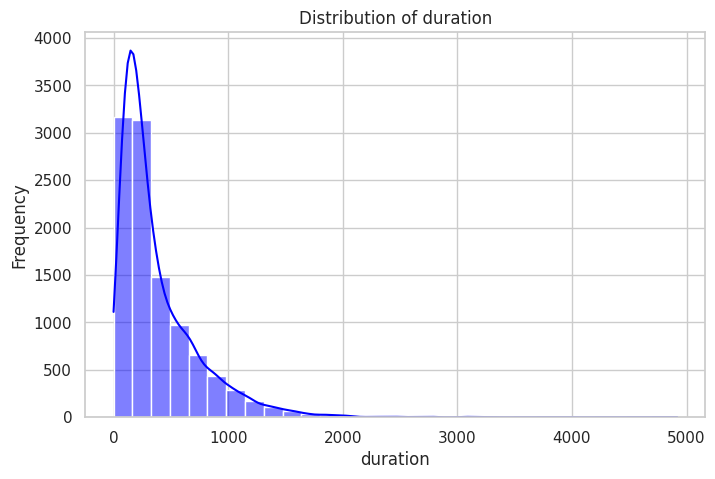

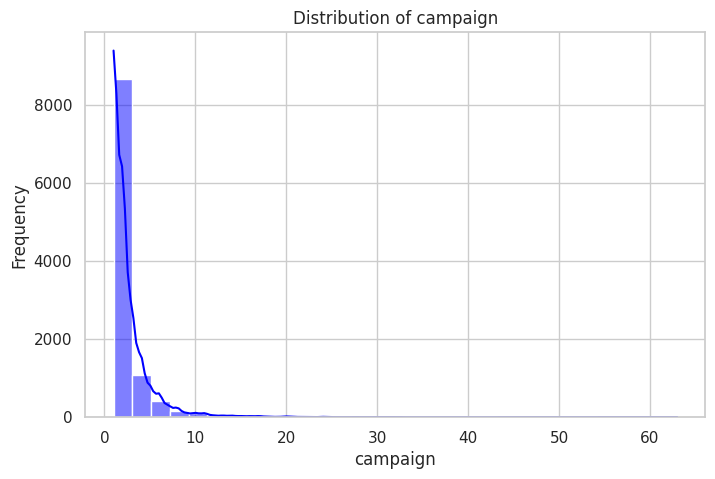

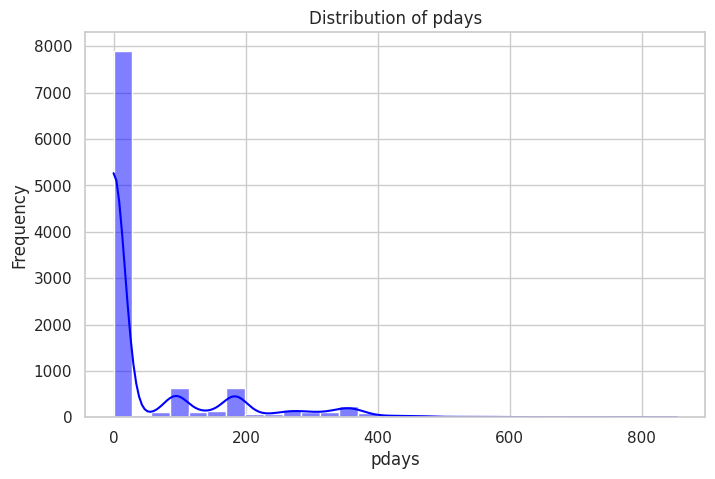

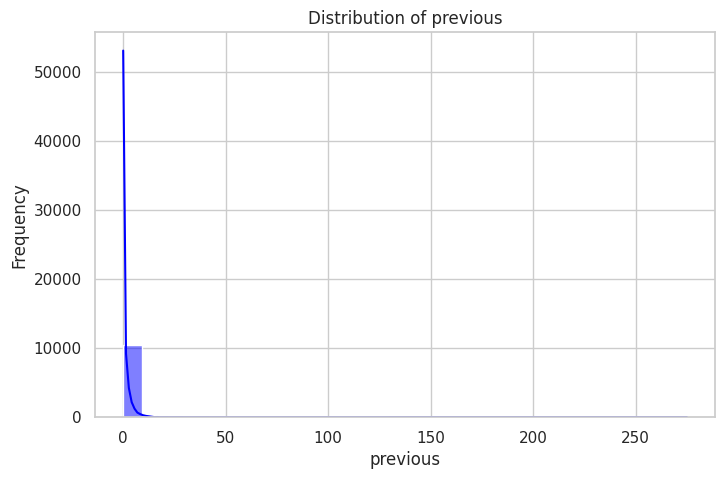

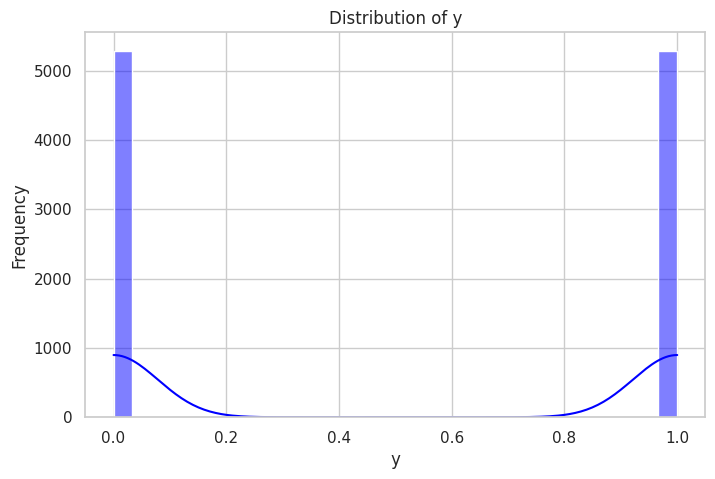

In [ ]:
# Set a consistent style for plots
sns.set(style="whitegrid")

# 1. Distribution of numerical features
numerical_columns = balanced_df.select_dtypes(include=['int64', 'float64']).columns
for column in numerical_columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(balanced_df[column], kde=True, bins=30, color='blue')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

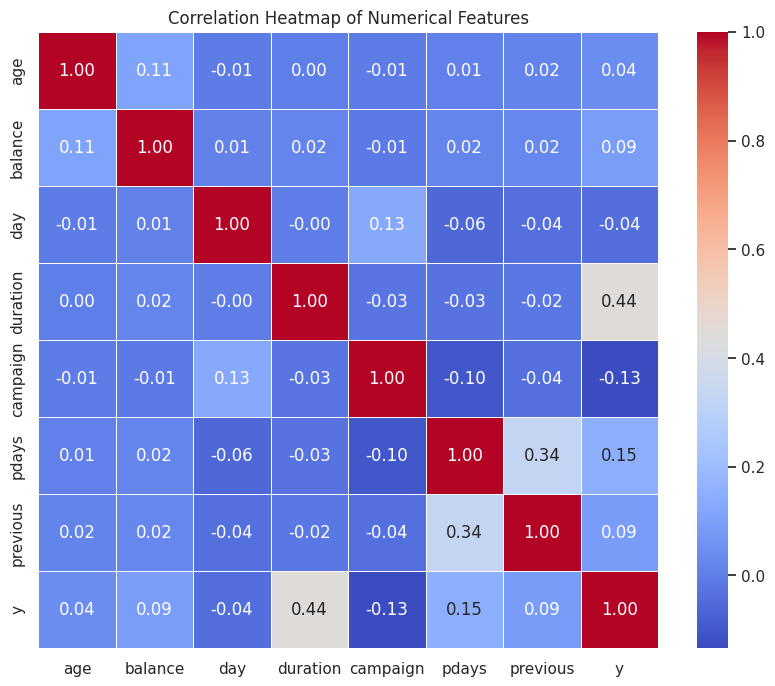

In [ ]:
# 2. Correlation heatmap of numerical features
plt.figure(figsize=(10, 8))
corr = balanced_df[numerical_columns].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

<ipython-input-20-9de90e61ab50>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='y', data=balanced_df, palette='viridis')


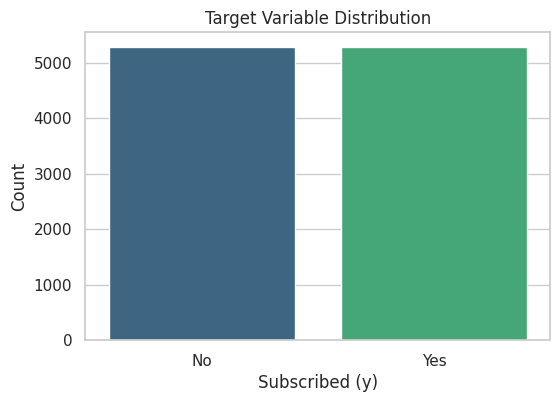

In [ ]:
# 3. Target variable distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='y', data=balanced_df, palette='viridis')
plt.title('Target Variable Distribution')
plt.xlabel('Subscribed (y)')
plt.ylabel('Count')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

<ipython-input-10-0926333170a8>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=balanced_df, palette='pastel', order=balanced_df[column].value_counts().index)


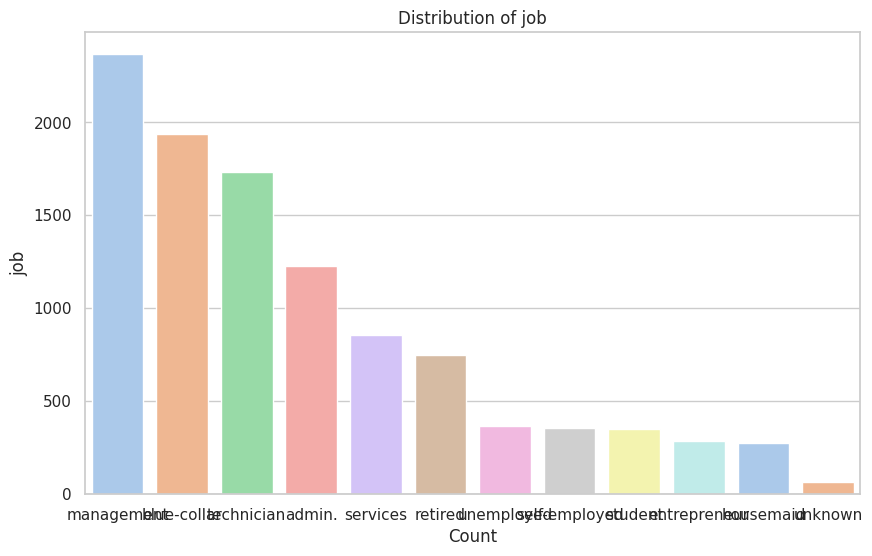

<ipython-input-10-0926333170a8>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=balanced_df, palette='pastel', order=balanced_df[column].value_counts().index)


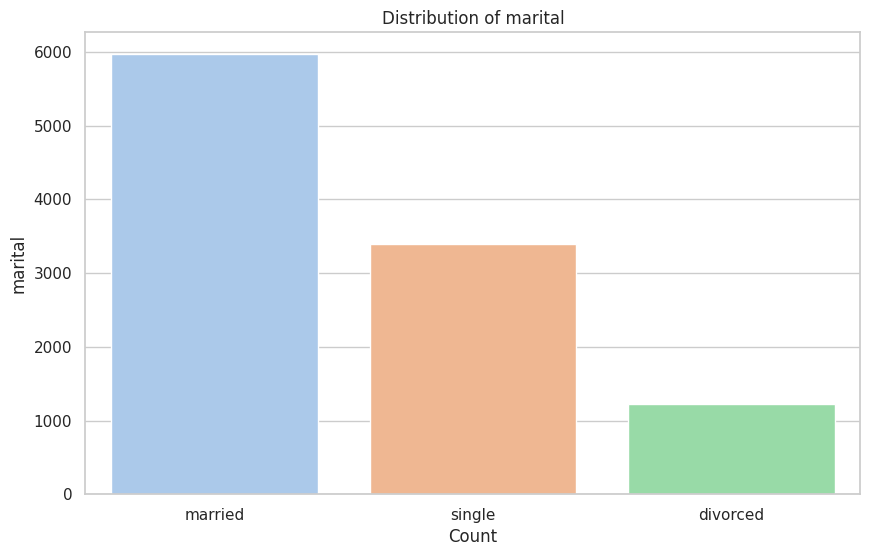

<ipython-input-10-0926333170a8>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=balanced_df, palette='pastel', order=balanced_df[column].value_counts().index)


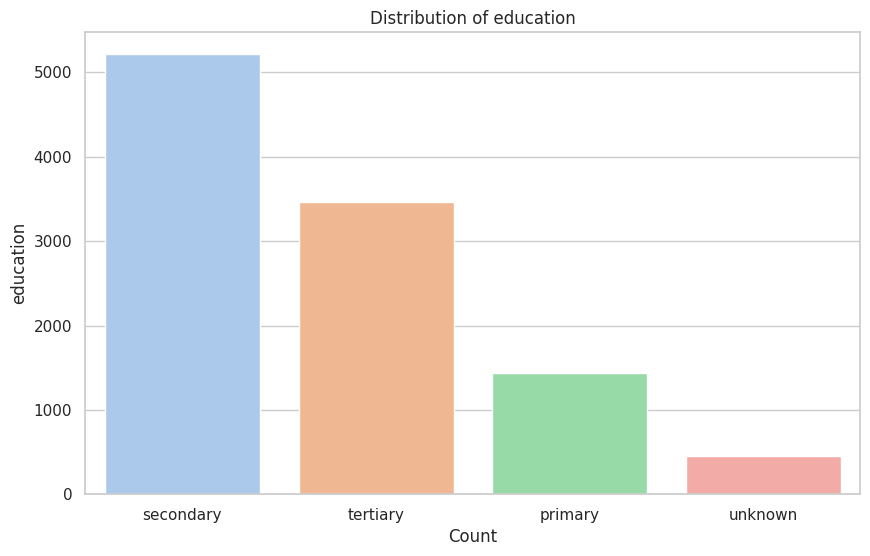

<ipython-input-10-0926333170a8>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=balanced_df, palette='pastel', order=balanced_df[column].value_counts().index)


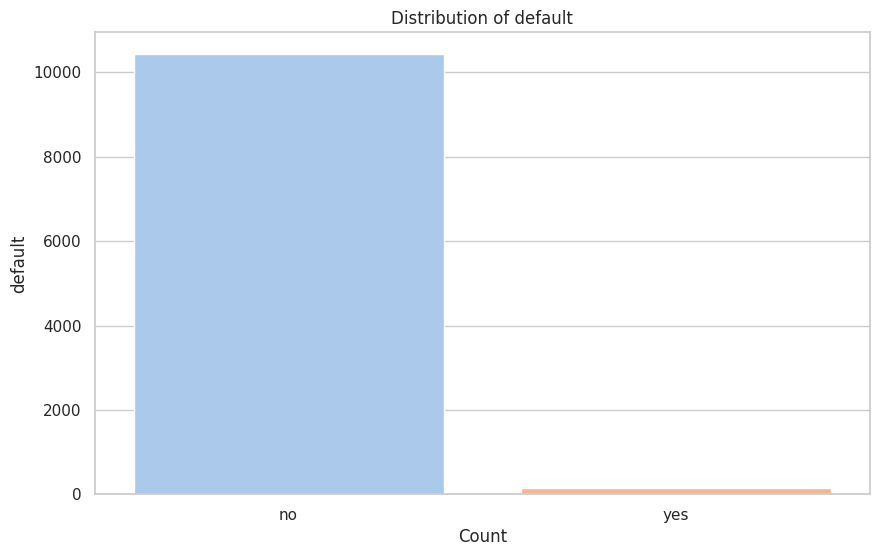

<ipython-input-10-0926333170a8>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=balanced_df, palette='pastel', order=balanced_df[column].value_counts().index)


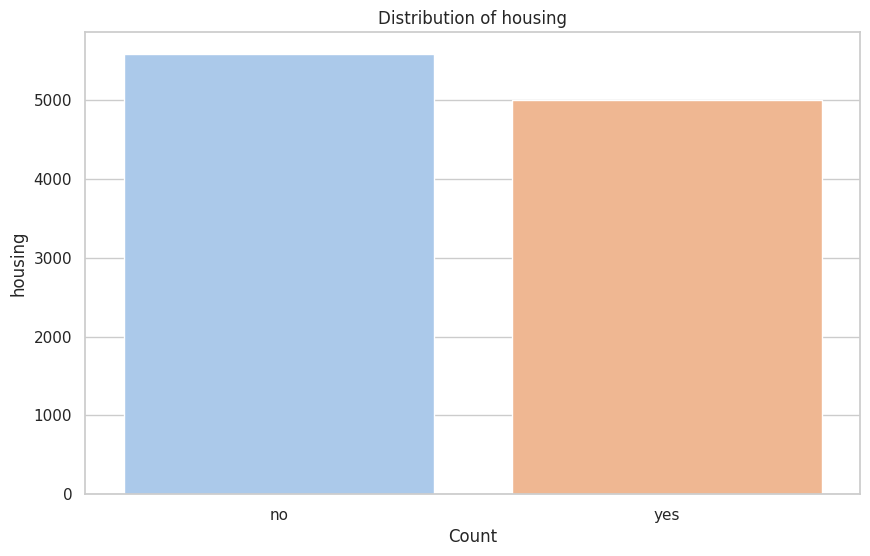

<ipython-input-10-0926333170a8>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=balanced_df, palette='pastel', order=balanced_df[column].value_counts().index)


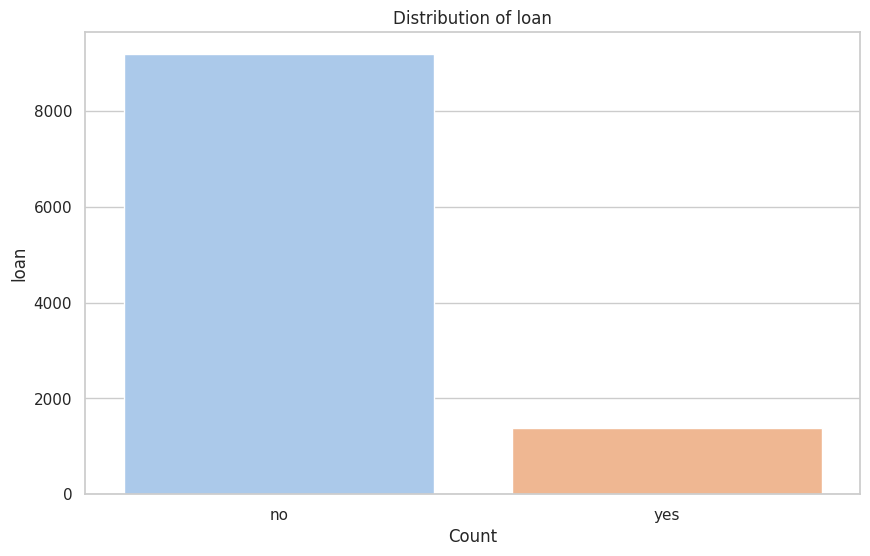

<ipython-input-10-0926333170a8>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=balanced_df, palette='pastel', order=balanced_df[column].value_counts().index)


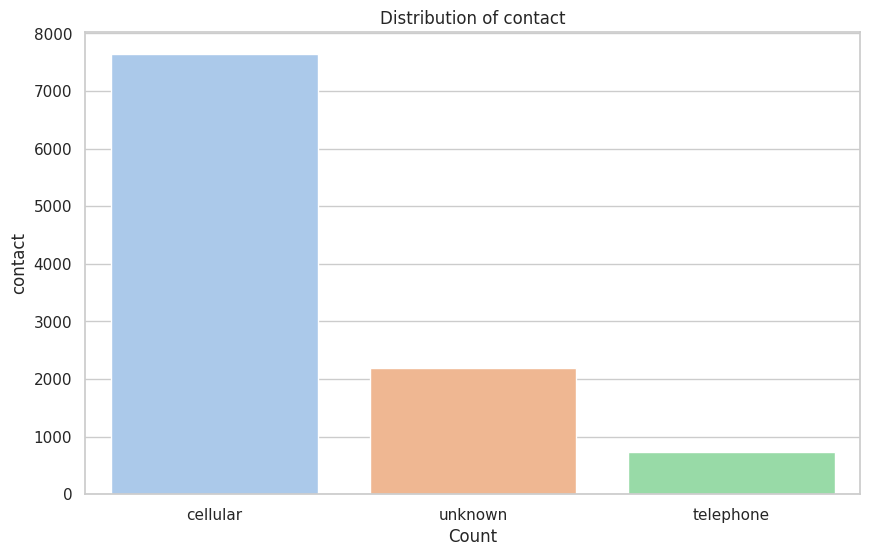

<ipython-input-10-0926333170a8>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=balanced_df, palette='pastel', order=balanced_df[column].value_counts().index)


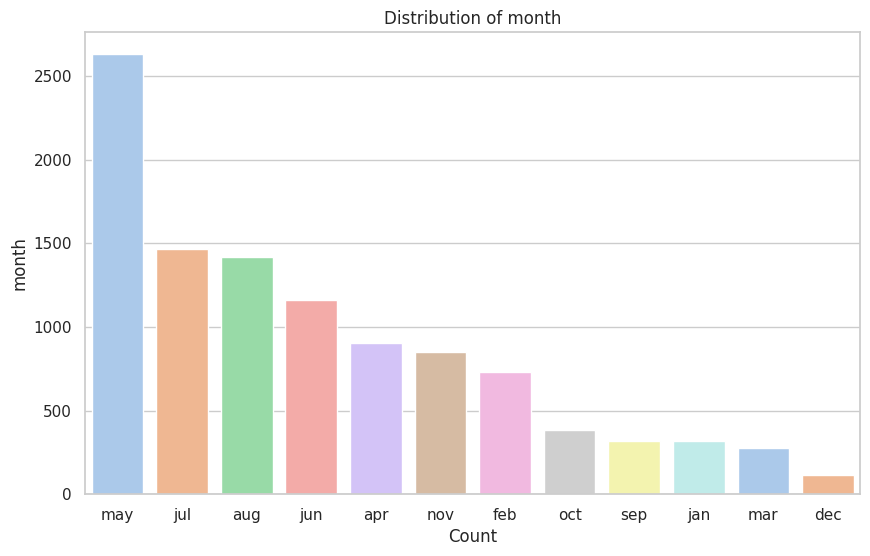

<ipython-input-10-0926333170a8>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=balanced_df, palette='pastel', order=balanced_df[column].value_counts().index)


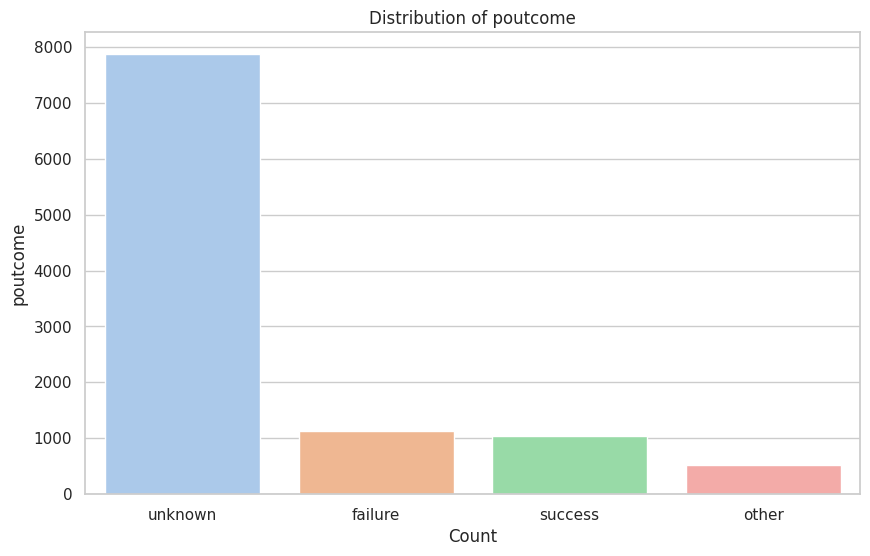

In [ ]:
# 4. Categorical feature distribution
categorical_columns = balanced_df.select_dtypes(include=['object']).columns
for column in categorical_columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=column, data=balanced_df, palette='pastel', order=balanced_df[column].value_counts().index)
    plt.title(f'Distribution of {column}')
    plt.ylabel(column)
    plt.xlabel('Count')
    plt.show()

# 5. Boxplots to visualize numerical features against the target
#for column in numerical_columns:
    #plt.figure(figsize=(8, 5))
    #sns.boxplot(x='y', y=column, data=data, palette='Set2')
    #plt.title(f'{column} vs. Target Variable')
    #plt.xlabel('Subscribed (y)')
    #plt.ylabel(column)
    #plt.xticks([0, 1], ['No', 'Yes'])
    #plt.show()

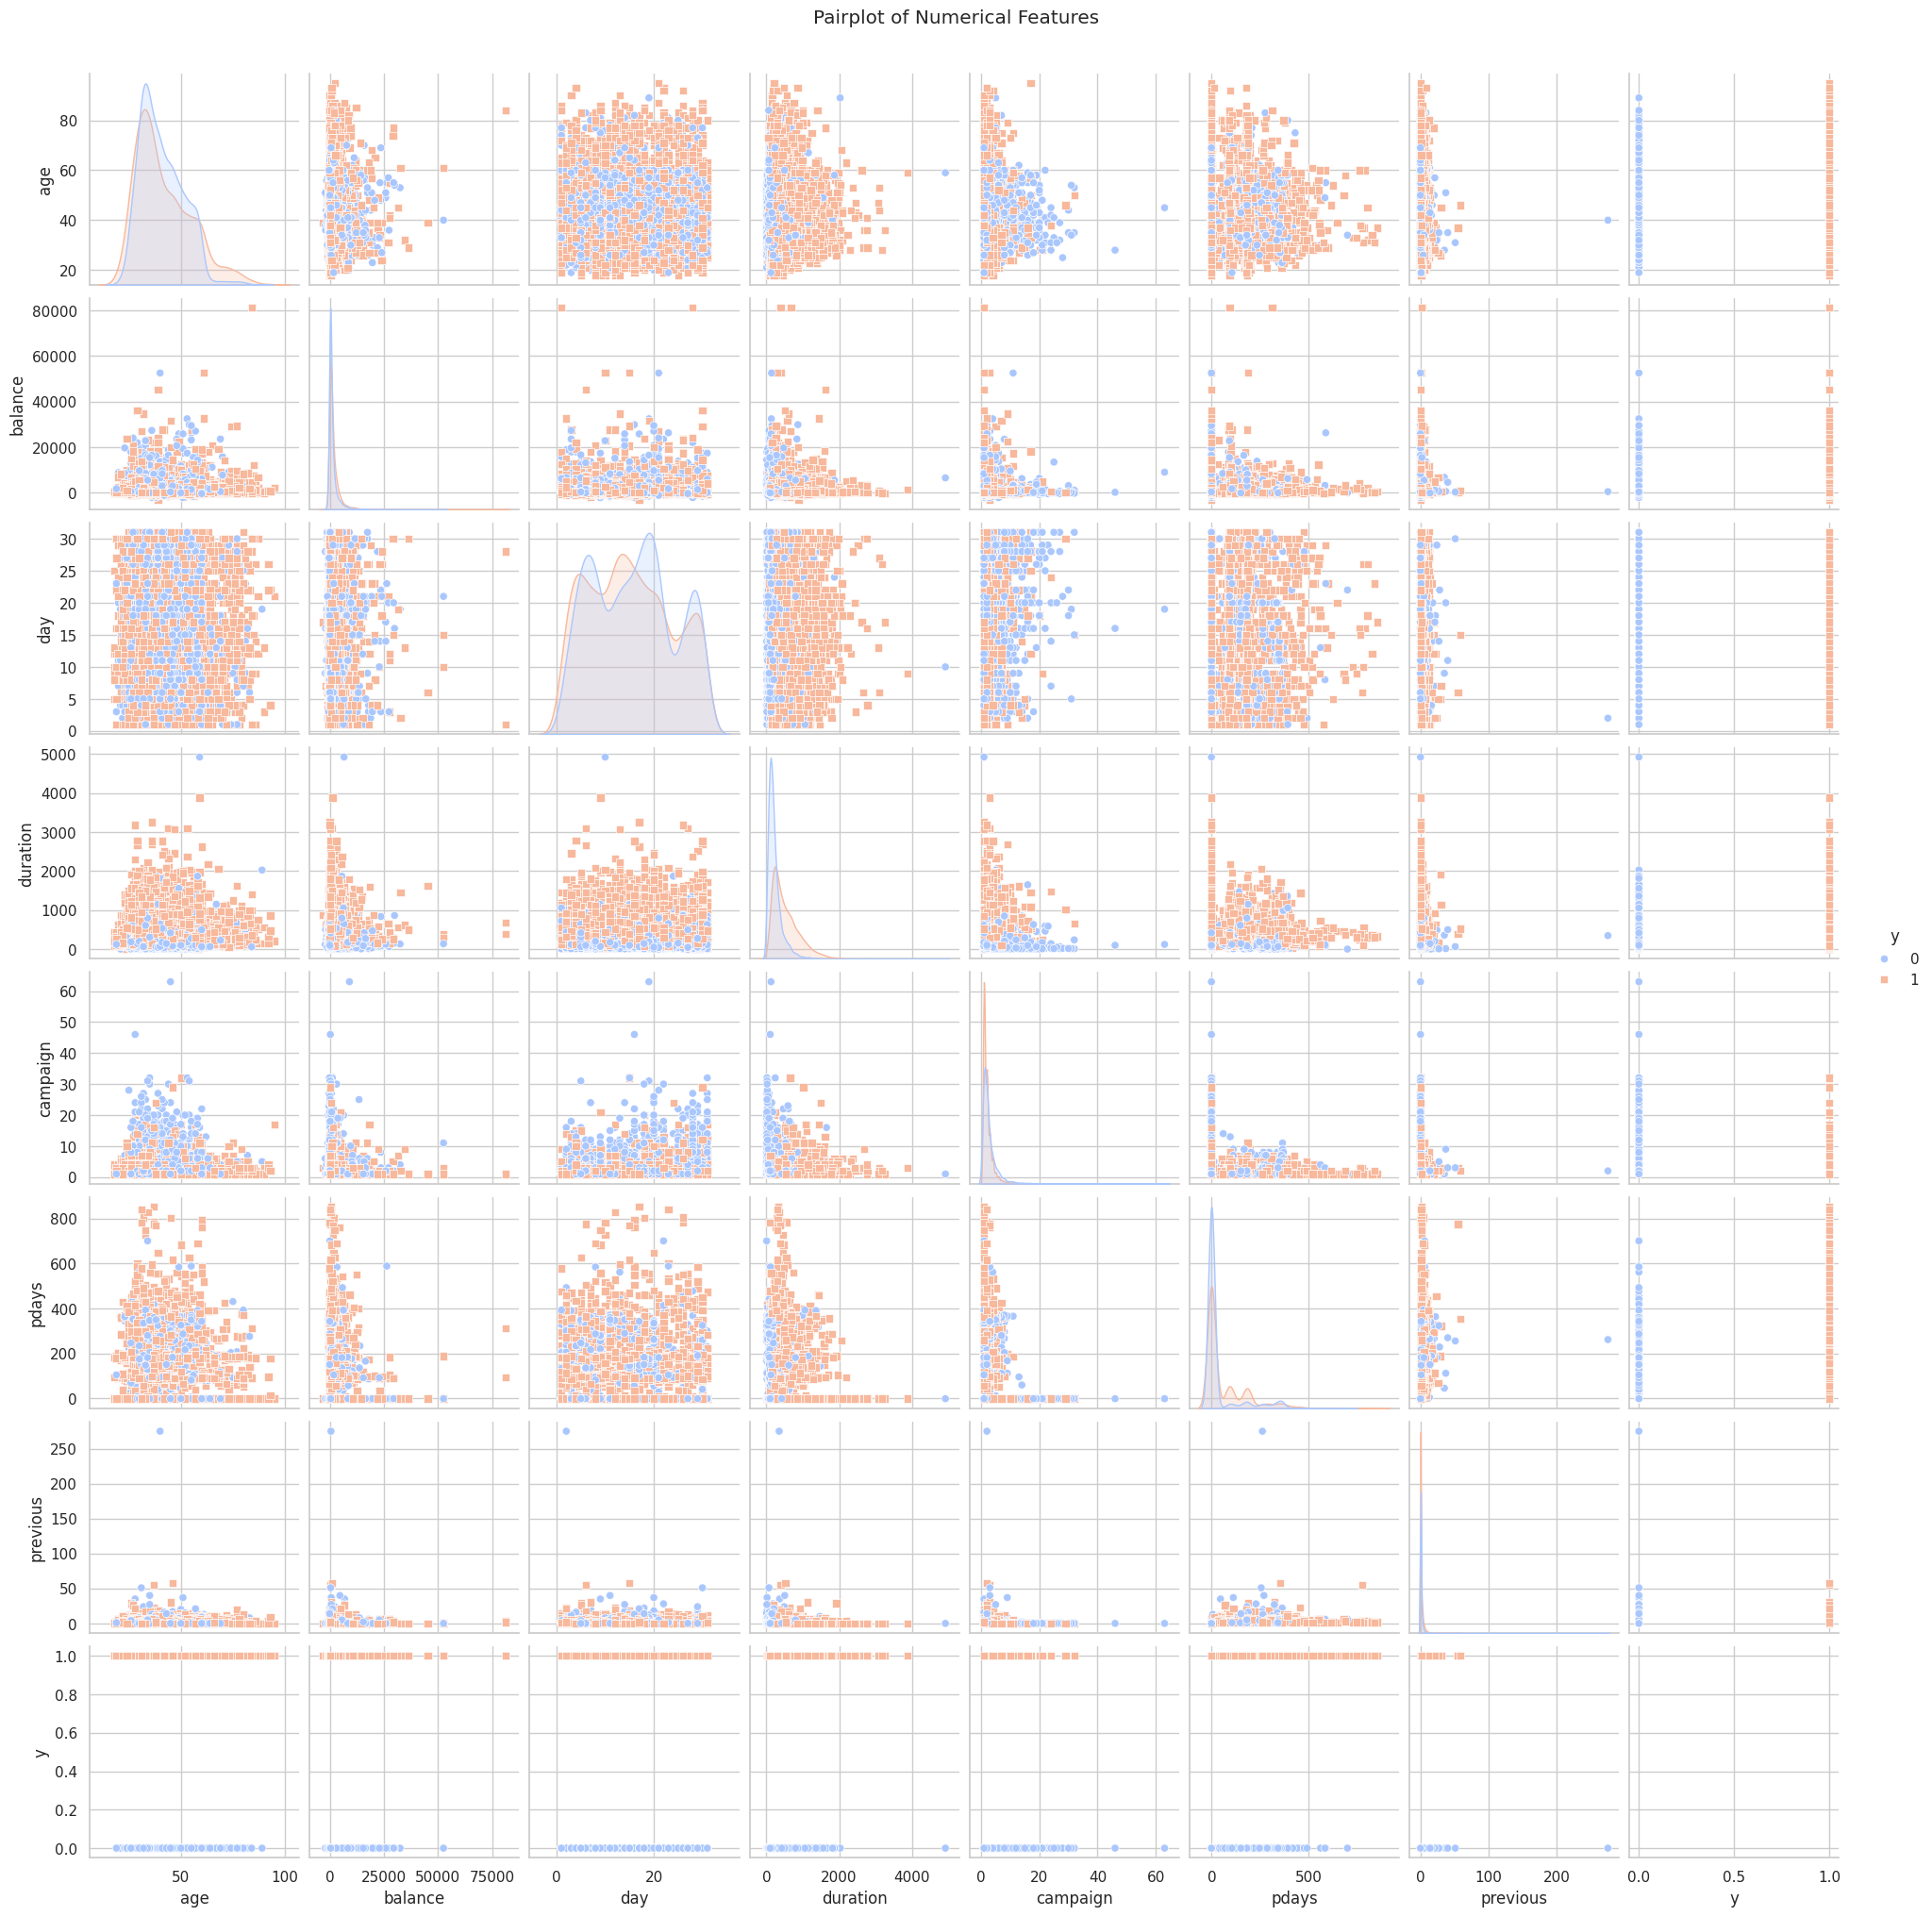

In [ ]:
# 6. Pairplot for numerical features and target variable
sns.pairplot(balanced_df, vars=numerical_columns, hue='y', palette='coolwarm', diag_kind='kde', markers=['o', 's'])
plt.suptitle('Pairplot of Numerical Features', y=1.02)
plt.show()

<ipython-input-22-0f6f0326fae1>:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(y='y', x=column, data=balanced_df, palette='muted', ci=None, estimator=lambda x: sum(x)/len(x))
<ipython-input-22-0f6f0326fae1>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='y', x=column, data=balanced_df, palette='muted', ci=None, estimator=lambda x: sum(x)/len(x))


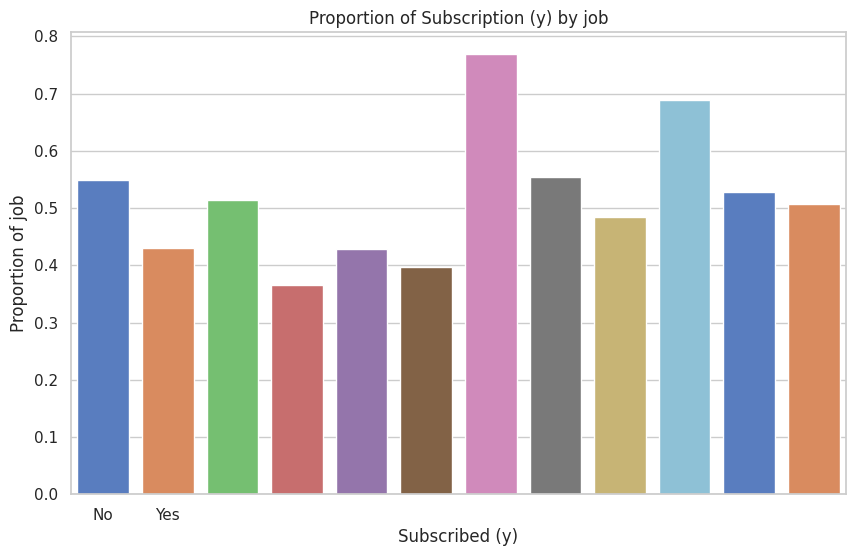

<ipython-input-22-0f6f0326fae1>:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(y='y', x=column, data=balanced_df, palette='muted', ci=None, estimator=lambda x: sum(x)/len(x))
<ipython-input-22-0f6f0326fae1>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='y', x=column, data=balanced_df, palette='muted', ci=None, estimator=lambda x: sum(x)/len(x))


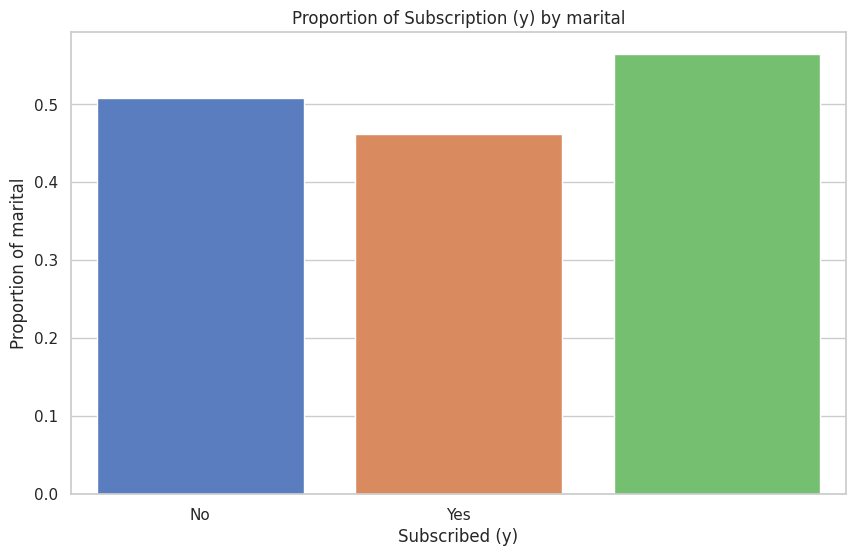

<ipython-input-22-0f6f0326fae1>:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(y='y', x=column, data=balanced_df, palette='muted', ci=None, estimator=lambda x: sum(x)/len(x))
<ipython-input-22-0f6f0326fae1>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='y', x=column, data=balanced_df, palette='muted', ci=None, estimator=lambda x: sum(x)/len(x))


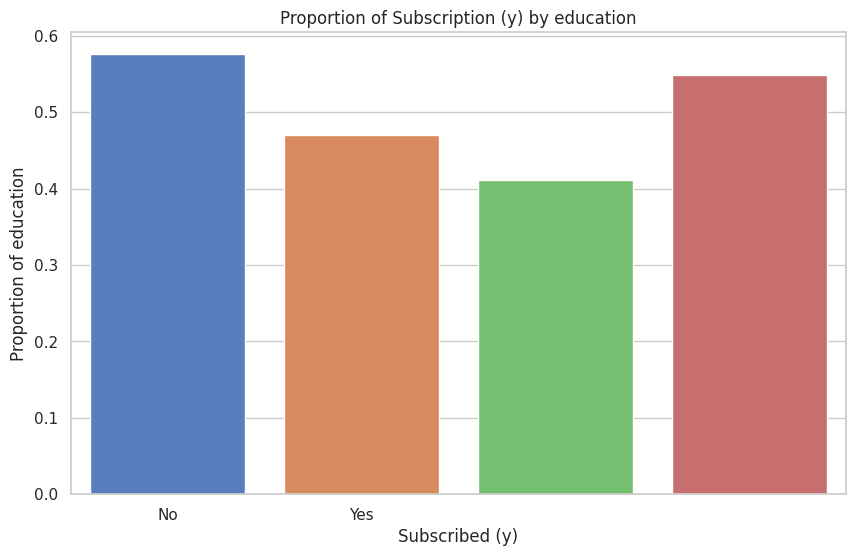

<ipython-input-22-0f6f0326fae1>:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(y='y', x=column, data=balanced_df, palette='muted', ci=None, estimator=lambda x: sum(x)/len(x))
<ipython-input-22-0f6f0326fae1>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='y', x=column, data=balanced_df, palette='muted', ci=None, estimator=lambda x: sum(x)/len(x))


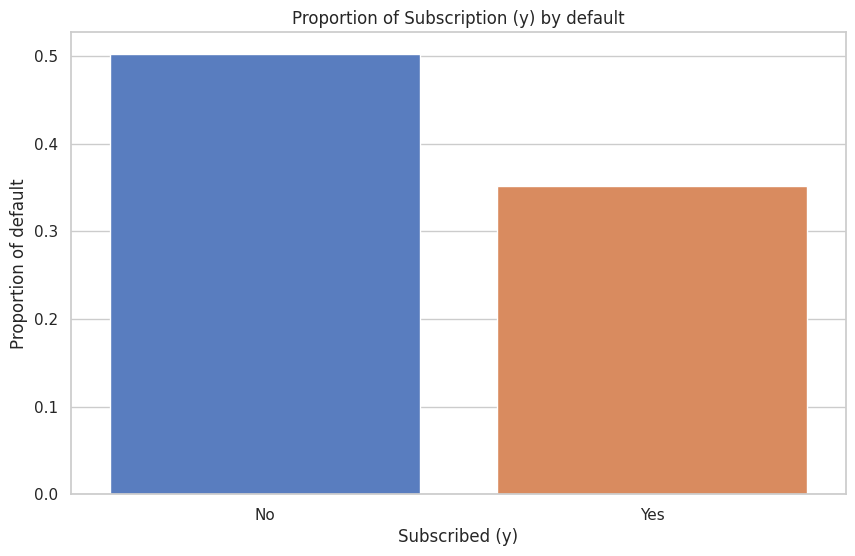

<ipython-input-22-0f6f0326fae1>:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(y='y', x=column, data=balanced_df, palette='muted', ci=None, estimator=lambda x: sum(x)/len(x))
<ipython-input-22-0f6f0326fae1>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='y', x=column, data=balanced_df, palette='muted', ci=None, estimator=lambda x: sum(x)/len(x))


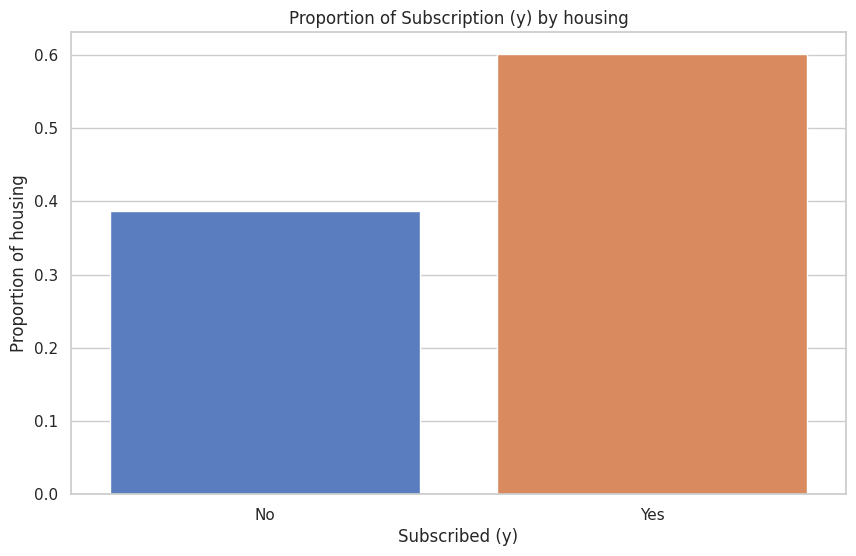

<ipython-input-22-0f6f0326fae1>:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(y='y', x=column, data=balanced_df, palette='muted', ci=None, estimator=lambda x: sum(x)/len(x))
<ipython-input-22-0f6f0326fae1>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='y', x=column, data=balanced_df, palette='muted', ci=None, estimator=lambda x: sum(x)/len(x))


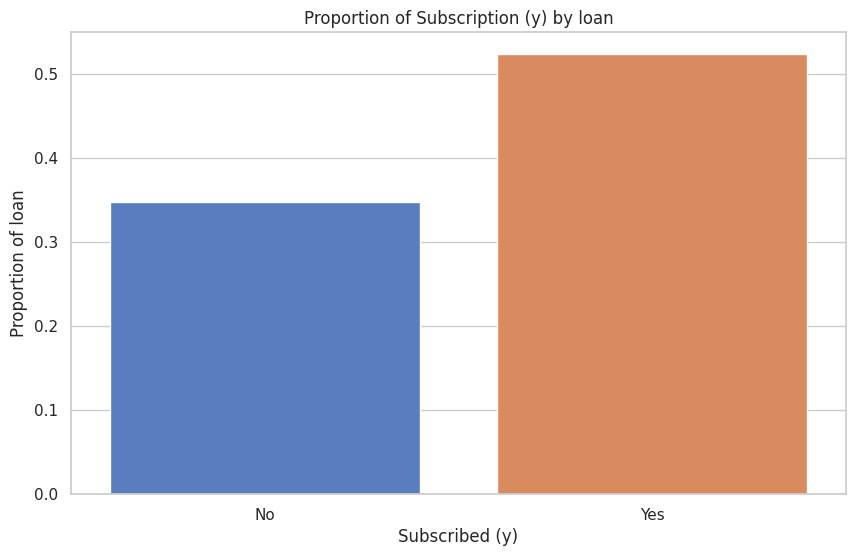

<ipython-input-22-0f6f0326fae1>:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(y='y', x=column, data=balanced_df, palette='muted', ci=None, estimator=lambda x: sum(x)/len(x))
<ipython-input-22-0f6f0326fae1>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='y', x=column, data=balanced_df, palette='muted', ci=None, estimator=lambda x: sum(x)/len(x))


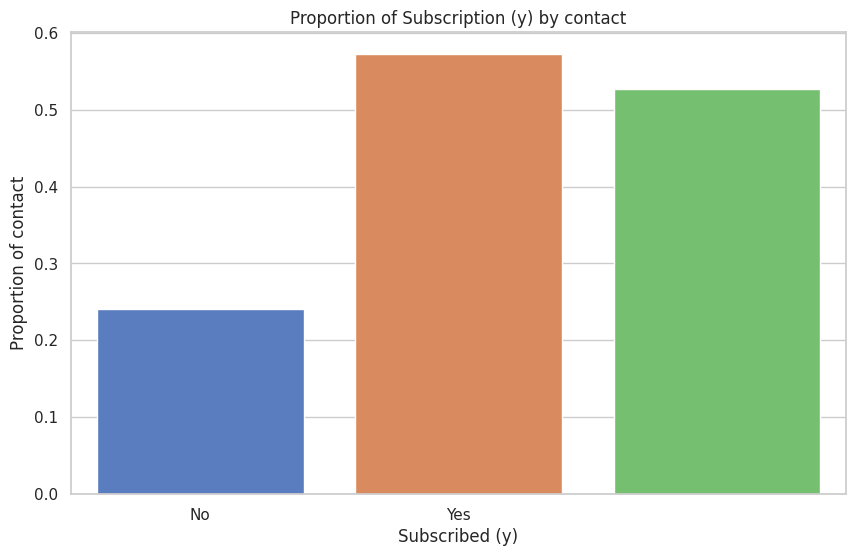

<ipython-input-22-0f6f0326fae1>:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(y='y', x=column, data=balanced_df, palette='muted', ci=None, estimator=lambda x: sum(x)/len(x))
<ipython-input-22-0f6f0326fae1>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='y', x=column, data=balanced_df, palette='muted', ci=None, estimator=lambda x: sum(x)/len(x))


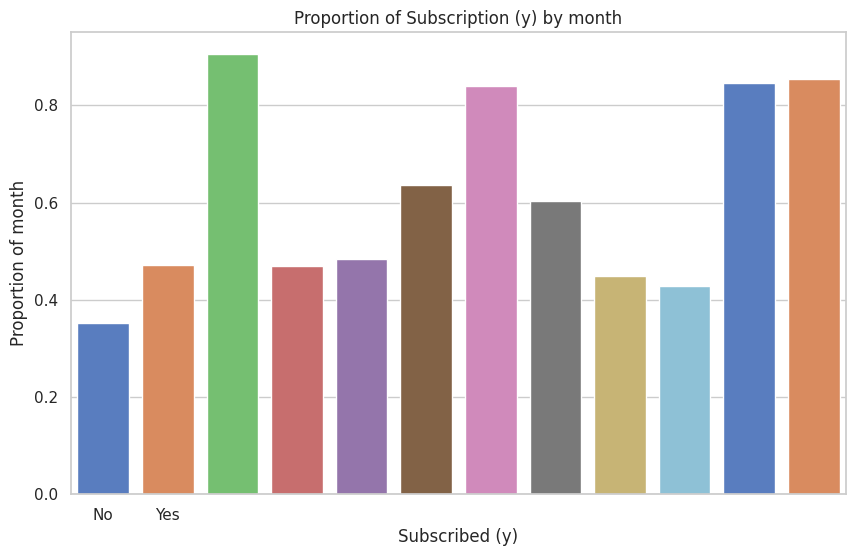

<ipython-input-22-0f6f0326fae1>:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(y='y', x=column, data=balanced_df, palette='muted', ci=None, estimator=lambda x: sum(x)/len(x))
<ipython-input-22-0f6f0326fae1>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='y', x=column, data=balanced_df, palette='muted', ci=None, estimator=lambda x: sum(x)/len(x))


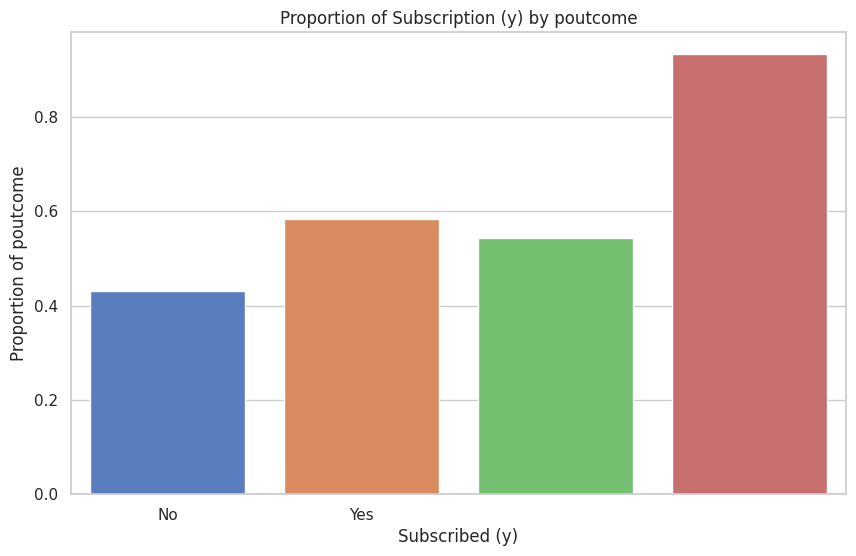

In [ ]:
# 7. Barplot for categorical variables grouped by target
for column in categorical_columns:
    plt.figure(figsize=(10, 6))
    sns.barplot(y='y', x=column, data=balanced_df, palette='muted', ci=None, estimator=lambda x: sum(x)/len(x))
    plt.title(f'Proportion of Subscription (y) by {column}')
    plt.xlabel('Subscribed (y)')
    plt.ylabel(f'Proportion of {column}')
    plt.xticks([0, 1], ['No', 'Yes'])
    plt.show()


In [ ]:
# Apply preprocessing
X_preprocessed = preprocessor.fit_transform(X)

# Convert preprocessed data to a DataFrame for statsmodels
# Get feature names after one-hot encoding
categorical_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_columns)
feature_names = np.concatenate([numerical_columns, categorical_feature_names])
X_preprocessed_df = pd.DataFrame(X_preprocessed.toarray(), columns=feature_names)

# Add constant for statsmodels
X_preprocessed_df = sm.add_constant(X_preprocessed_df)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed_df, y, test_size=0.2, random_state=42, stratify=y)

# Logistic Regression using statsmodels
logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()

# Print summary to see p-values and coefficients
print(result.summary())

NameError: name 'preprocessor' is not defined

**Age:**

Null Hypothesis: Age has no effect on the likelihood of subscribing to a term deposit.

Alternative Hypothesis: Age affects the likelihood of subscribing to a term deposit.

**Balance:**

Null Hypothesis: Balance has no effect on the likelihood of subscribing to a term deposit.

Alternative Hypothesis: Balance affects the likelihood of subscribing to a term deposit.

**Duration:**

Null Hypothesis: Duration has no effect on the likelihood of subscribing to a term deposit.

Alternative Hypothesis : Duration affects the likelihood of subscribing to a term deposit.

**Campaign:**

Null Hypothesis: Campaign has no effect on the likelihood of subscribing to a term deposit.

Alternative Hypothesis: Campaign affects the likelihood of subscribing to a term deposit.


Here, we can also check the slope, if positive slope will increase the probability to  subscribe term deposit ,  with a negative slope will reduce the probability.


(yesterday, the code can run, the result for age shows p-value > 0.05, others <0.05)


Balance, duration, and campaign significantly influence a client's likelihood to subscribe to a term deposit, with p-value <0.05


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define Logistic Regression pipeline
logistic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=5000, class_weight='balanced'))
])

# Train and evaluate Logistic Regression
logistic_pipeline.fit(X_train, y_train)
y_pred_logistic = logistic_pipeline.predict(X_test)
print("Logistic Regression Results:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logistic))
print("Classification Report:")
print(classification_report(y_test, y_pred_logistic))
print(f"ROC-AUC Score: {roc_auc_score(y_test, logistic_pipeline.predict_proba(X_test)[:, 1]):.4f}")
print(f"Accuracy Score: {accuracy_score(y_test, y_pred_logistic):.4f}")

Logistic Regression Results:
Confusion Matrix:
[[894 164]
 [190 868]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1058
           1       0.84      0.82      0.83      1058

    accuracy                           0.83      2116
   macro avg       0.83      0.83      0.83      2116
weighted avg       0.83      0.83      0.83      2116

ROC-AUC Score: 0.9126
Accuracy Score: 0.8327


In [ ]:
# SVM
# Split data into training and testing sets
# Redefine X and y using the balanced_df
X = balanced_df.drop('y', axis=1)
y = balanced_df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the SVM model
svm_model = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)

# Create a complete pipeline with preprocessing and SVM model
svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', svm_model)
])

# Train the model
svm_pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred = svm_pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred)

print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Using decision function scores to calculate MSE (not probabilities)
# Use svm_pipeline instead of svmmodel
decision_scores = svm_pipeline.decision_function(X_test)
mse_svm = mean_squared_error(y_test, decision_scores)
print("MSE for SVM using decision function:", mse_svm)

              precision    recall  f1-score   support

           0       0.88      0.81      0.84      1058
           1       0.82      0.89      0.85      1058

    accuracy                           0.85      2116
   macro avg       0.85      0.85      0.85      2116
weighted avg       0.85      0.85      0.85      2116

Accuracy: 0.8492438563327032
MSE for SVM using decision function: 1.4614968504852315


In [ ]:
# Define Random Forest pipeline
random_forest_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))
])

# Train and evaluate Random Forest
random_forest_pipeline.fit(X_train, y_train)
y_pred_rf = random_forest_pipeline.predict(X_test)
print("Random Forest Results:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))
print(f"ROC-AUC Score: {roc_auc_score(y_test, random_forest_pipeline.predict_proba(X_test)[:, 1]):.4f}")
print(f"Accuracy Score: {accuracy_score(y_test, y_pred_rf):.4f}")




Random Forest Results:
Confusion Matrix:
[[875 183]
 [117 941]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.83      0.85      1058
           1       0.84      0.89      0.86      1058

    accuracy                           0.86      2116
   macro avg       0.86      0.86      0.86      2116
weighted avg       0.86      0.86      0.86      2116

ROC-AUC Score: 0.9276
Accuracy Score: 0.8582


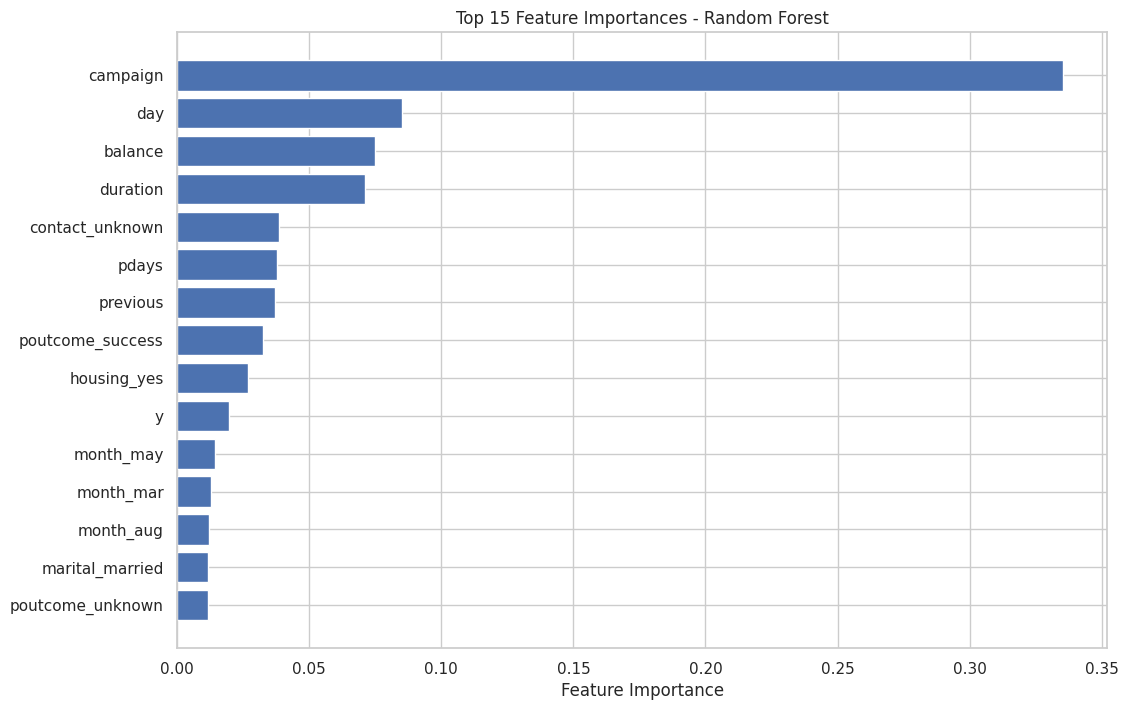

In [ ]:
# Apply preprocessing
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train_preprocessed, y_train)

# Get feature names
categorical_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_columns)
feature_names = np.concatenate([numerical_columns[1:], categorical_feature_names])

# Get feature importances
feature_importances = rf_model.feature_importances_
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'].iloc[:15], importance_df['Importance'].iloc[:15], align='center')
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances - Random Forest')
plt.show()


<ipython-input-47-bca9319b7913>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = encoder.fit_transform(X[col])
<ipython-input-47-bca9319b7913>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = encoder.fit_transform(X[col])
<ipython-input-47-bca9319b7913>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

[Text(0.5, 0.875, 'duration <= 206.5\ngini = 0.5\nsamples = 10578\nvalue = [5289, 5289]'),
 Text(0.25, 0.625, 'pdays <= 0.0\ngini = 0.346\nsamples = 4212\nvalue = [3275, 937]'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'month <= 9.5\ngini = 0.261\nsamples = 3269\nvalue = [2765, 504]'),
 Text(0.0625, 0.125, 'gini = 0.235\nsamples = 3149\nvalue = [2721, 428]'),
 Text(0.1875, 0.125, 'gini = 0.464\nsamples = 120\nvalue = [44, 76]'),
 Text(0.375, 0.375, 'poutcome <= 1.5\ngini = 0.497\nsamples = 943\nvalue = [510.0, 433.0]'),
 Text(0.3125, 0.125, 'gini = 0.409\nsamples = 655\nvalue = [467, 188]'),
 Text(0.4375, 0.125, 'gini = 0.254\nsamples = 288\nvalue = [43, 245]'),
 Text(0.75, 0.625, 'duration <= 395.5\ngini = 0.433\nsamples = 6366\nvalue = [2014, 4352]'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'contact <= 1.5\ngini = 0.497\nsamples = 2839\nvalue = [1315, 1524]'),
 Text(0.5625, 0.125, 'gini = 0.467\nsamples = 2378\nvalue = [883, 1495]'),
 Text(0.6875, 0.125, 'gini = 0

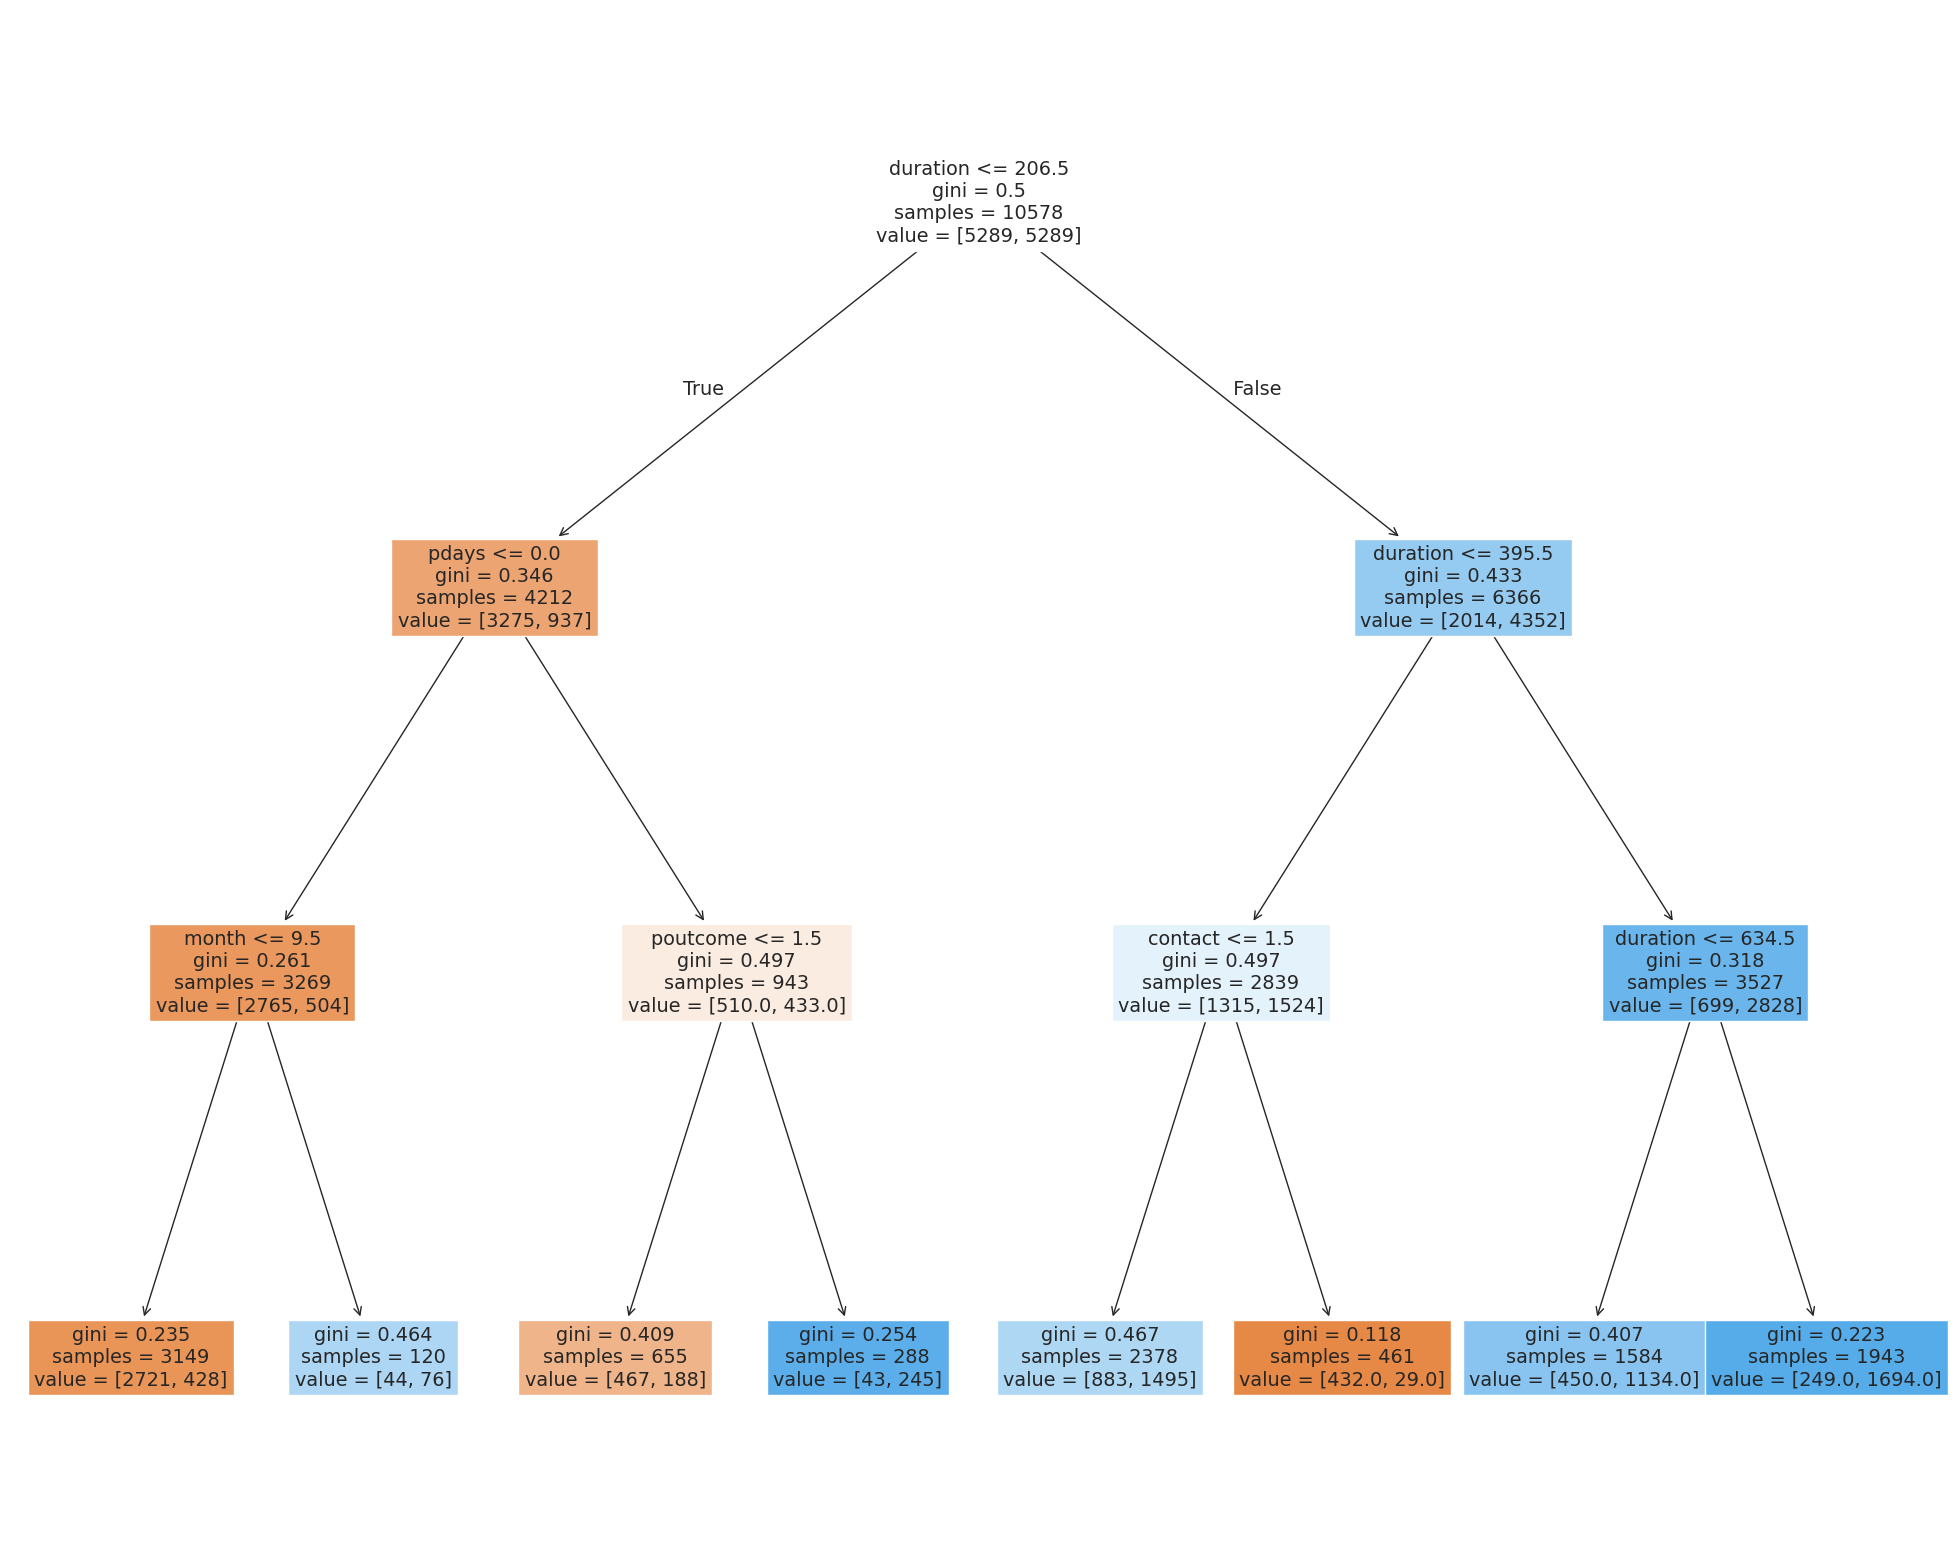

In [ ]:
# Decision Tree

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder  # Import LabelEncoder

xvars = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']
X = balanced_df[xvars]
y = balanced_df['y']

# Create a LabelEncoder instance
encoder = LabelEncoder()

# Encode categorical features in X
for col in X.select_dtypes(include=['object']).columns:
    X[col] = encoder.fit_transform(X[col])

small_tree_classifier = DecisionTreeClassifier(max_depth = 3).fit(X, y)

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(25,20))
plot_tree(small_tree_classifier, feature_names = xvars, filled = True)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
small_tree_classifier.fit(X_train, y_train)
y_pred = small_tree_classifier.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.85      0.68      0.76      1565
           1       0.74      0.88      0.81      1609

    accuracy                           0.78      3174
   macro avg       0.79      0.78      0.78      3174
weighted avg       0.79      0.78      0.78      3174



**Model Performance Summary**

**Random Forest outperforms other models:** With the highest Recall, F1-Score, and Accuracy , Random Forest is the most effective model for predicting whether a client will subscribe to a term deposit.

**Logistic Regression and SVM are competitive:** Both Logistic Regression and SVM show strong performance, making them reliable alternatives.

**Decision Tree performs the weakest:** Decision Tree has the lowest Accuracy and F1-Score, suggesting it is less suitable for this classification task compared to other models.



Overall, leveraging the Random Forest model can help the bank optimize its marketing strategies by accurately identifying potential clients likely to subscribe to term deposits.

# **Conclusion**:

Reduce Contact Frequency:
1. Avoid overwhelming customers with too many interactions.
2. Focus on optimizing the timing and relevance of campaigns.

Enhance Call Quality:
1. Train agents to prioritize meaningful and engaging conversations.
Aim for longer, value-driven interactions that build trust.

Target High-Value Customers:
1. Prioritize customers with higher account balances.
2. Leverage data on successful prior engagements to tailor future strategies.

Utilize Seasonal Trends:
1. Align campaigns and promotions with seasonal behavior patterns.
2. Capitalize on periods of high engagement to maximize ROI.